# Exploratory analysis of the Podcast Reviews dataset

The file provides the exploratory analysis of the Podcast Reviews SQLite dataset (https://www.kaggle.com/datasets/thoughtvector/podcastreviews/versions/28from , version 28) the Kaggle data repository which contains four tables: Podcasts, Reviews, Categories and Runs. 

The Podcasts table contains information about more than 100 thousand podcasts and includes these columns: podcast_id PRIMARY KEY, itunes_id, slug, itunes_url, title (i.e. titles of podcasts). The Reviews table contains information about more than 2 million reviews of podcasts contained in the Podcasts table. The table includes columns podcast_id FOREIGN KEY, title (i.e. review's titles), content (texts of reviews), rating (numerical variable), author_id and created_at (date-type variable). The Categories table contains data about thematic categories of podcasts and its columns are podcast_id FOREIGN KEY and category (110 categories in total as atributes of podcasts). The Runs table includes 16 rows and three columns (run_at, max_rowid, reviews_added). The table contains information about the formation of the Podcast dataset (the time when the dataset was updated and the numbers of reviews which were added to the dataset in each update.

After the initial examination of the data, the purpose of the data analysis was set to better understand the demand-supply and competitive environment in the podcast market. Such undestanding could be valuable for someone who considers initiating a new podcast and has to make decisions on the topic of the podcast, etc.

As this project is a part of 'Data Analysis' sprint, additional objectives of the analysis are:
- Practice working with SQLite datasets.
- Practice performing EDA.
- Practice applying statistical inference procedures.
- Practice visualizing data with Matplotlib & Seaborn.
- Practice creating dashboards with Google Data Studio (the Data Studio dashboard file will be atached separately).
- Practice reading data, performing queries and filtering data using SQL and Pandas.

The exploratory analysis of the Podcast dataset will consist of two major parts:
 1. quering the full dataframes;
 2. making inferences from samples of the data (in the cases when the analysis of the full database is not possible due to computer data processing limitations, mainly in the case of sentiment analysis of reviews).

## Importing libraries and understanding the data

The first step of the analysis is to import data from the Kaggle website and to import Python libraries which will be used for the analysis. The main libraries which will be used for the manipulation with data are pandas, duckdb, sqlite3 (to perform sql queries, to save the to dataframes and to analyse them, to create random samples from databases). Matplotlib and seaborn will be used for data visualization. Numpy, Scipy and Statsmodels will be used for conducting statistical tests, calculating confidence intervals.

Also a pretrained language model will be used for sentiment analysis of the content of podcast reviews. For this purpose Pipeline module from the Transformers library is imported (see https://huggingface.co/blog/sentiment-analysis-python).


In [1]:
import sqlite3
import duckdb
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats as st
from scipy.stats import chi2_contingency, norm 
from statsmodels.stats.proportion import proportions_ztest
from transformers import pipeline
import random
from statsmodels.stats.proportion import proportion_confint
from scipy.stats import f_oneway
import math

/Users/user/miniforge3/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Which data tables are included into the dataset?

In order to understand the structure of the dataset, the connection to the SQLite dataset was built and queries to select all data from all three tables were performed and data were saved to dataframes.

In [2]:
con = sqlite3.connect("podcast.sqlite")
categories = pd.read_sql_query("""SELECT * FROM categories""", con)
podcasts = pd.read_sql_query("""SELECT * FROM podcasts""", con)
reviews = pd.read_sql_query("""SELECT * FROM reviews""", con)
runs = pd.read_sql_query("""SELECT * FROM runs""", con)

con.close()

In [3]:
reviews.to_csv('reviews.csv', index=False)
categories.to_csv('categories.csv', index=False)
podcasts.to_csv('podcasts.csv', index=False)

The inspection of the dataframes revealed that the reviews dataframe contains 2067529 rows. The podcasts dataframe includes 110024 rows, the categories dataframe contains 212372 rows, and runs dataframe contains 16 rows (see bellow). As categories and raviews dataframes are longer than the podcasts dataframe, it means that at least for some of the podcasts the numbers of corresponding reviews and categories are more than one.

In [4]:
categories.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 212372 entries, 0 to 212371
Data columns (total 2 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   podcast_id  212372 non-null  object
 1   category    212372 non-null  object
dtypes: object(2)
memory usage: 3.2+ MB


In [5]:
podcasts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110024 entries, 0 to 110023
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   podcast_id  110024 non-null  object
 1   itunes_id   110024 non-null  int64 
 2   slug        110024 non-null  object
 3   itunes_url  110024 non-null  object
 4   title       110024 non-null  object
dtypes: int64(1), object(4)
memory usage: 4.2+ MB


In [6]:
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2067529 entries, 0 to 2067528
Data columns (total 6 columns):
 #   Column      Dtype 
---  ------      ----- 
 0   podcast_id  object
 1   title       object
 2   content     object
 3   rating      int64 
 4   author_id   object
 5   created_at  object
dtypes: int64(1), object(5)
memory usage: 94.6+ MB


In [7]:
runs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16 entries, 0 to 15
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   run_at         16 non-null     object
 1   max_rowid      16 non-null     int64 
 2   reviews_added  16 non-null     int64 
dtypes: int64(2), object(1)
memory usage: 512.0+ bytes


In [8]:
podcasts.head()

,podcast_id,itunes_id,slug,itunes_url,title
0,a00018b54eb342567c94dacfb2a3e504,1313466221,scaling-global,https://podcasts.apple.com/us/podcast/scaling-...,Scaling Global
1,a00043d34e734b09246d17dc5d56f63c,158973461,cornerstone-baptist-church-of-orlando,https://podcasts.apple.com/us/podcast/cornerst...,Cornerstone Baptist Church of Orlando
2,a0004b1ef445af9dc84dad1e7821b1e3,139076942,mystery-dancing-in-the-dark,https://podcasts.apple.com/us/podcast/mystery-...,Mystery: Dancing in the Dark
3,a00071f9aaae9ac725c3a586701abf4d,1332508972,kts-money-matters,https://podcasts.apple.com/us/podcast/kts-mone...,KTs Money Matters
4,a000a500f06555f81220c3eb641aded7,1544900779,word-on-the-street-w-dreak-swift,https://podcasts.apple.com/us/podcast/word-on-...,Word on the Street w/ Dreak Swift


In [9]:
reviews.head()

,podcast_id,title,content,rating,author_id,created_at
0,c61aa81c9b929a66f0c1db6cbe5d8548,really interesting!,Thanks for providing these insights. Really e...,5,F7E5A318989779D,2018-04-24T12:05:16-07:00
1,c61aa81c9b929a66f0c1db6cbe5d8548,Must listen for anyone interested in the arts!!!,Super excited to see this podcast grow. So man...,5,F6BF5472689BD12,2018-05-09T18:14:32-07:00
2,ad4f2bf69c72b8db75978423c25f379e,nauseatingly left,"I'm a liberal myself, but its pretty obvious a...",1,1AB95B8E6E1309E,2019-06-11T14:53:39-07:00
3,ad4f2bf69c72b8db75978423c25f379e,Diverse stories,I find Tedx talks very inspirational but I oft...,5,11BB760AA5DEBD1,2018-05-31T13:08:09-07:00
4,ad4f2bf69c72b8db75978423c25f379e,👍👍👍👍,"I love this podcast, it is so good.",5,D86032C8E57D15A,2019-06-19T13:56:05-07:00


In [10]:
reviews['created_at'] = pd.to_datetime(pd.to_datetime(reviews['created_at']).dt.date)
reviews.head()

,podcast_id,title,content,rating,author_id,created_at
0,c61aa81c9b929a66f0c1db6cbe5d8548,really interesting!,Thanks for providing these insights. Really e...,5,F7E5A318989779D,2018-04-24
1,c61aa81c9b929a66f0c1db6cbe5d8548,Must listen for anyone interested in the arts!!!,Super excited to see this podcast grow. So man...,5,F6BF5472689BD12,2018-05-09
2,ad4f2bf69c72b8db75978423c25f379e,nauseatingly left,"I'm a liberal myself, but its pretty obvious a...",1,1AB95B8E6E1309E,2019-06-11
3,ad4f2bf69c72b8db75978423c25f379e,Diverse stories,I find Tedx talks very inspirational but I oft...,5,11BB760AA5DEBD1,2018-05-31
4,ad4f2bf69c72b8db75978423c25f379e,👍👍👍👍,"I love this podcast, it is so good.",5,D86032C8E57D15A,2019-06-19


In [11]:
runs.head()

,run_at,max_rowid,reviews_added
0,2021-05-10 02:53:00,3266481,1215223
1,2021-06-06 21:34:36,3300773,13139
2,2021-07-02 18:04:55,3329699,11561
3,2021-08-01 17:54:42,3360315,11855
4,2021-09-02 18:00:30,3390165,11714


## Preparing for the data analysis

The following preparatory steps for the exploratory data analysis were conducted:
- functions which will be used for the further analysis were created;
- data in the dataframes were checked for missing values;
- raising research questions and research hypotheses.

### Creating functions for data analysis

Functions were created for the following purposes (see bellow):
- checking for missing values;
- finding outliers;
- conducting statistical tests (chi square test, t test, Kruscal Wallis test, permutation test);
- identifying confidence intervals;
- transforming data (getting percent values, transposing, etc.);
- visualizing data;
- sampling data and identifying positive or negative sentimens in the reviews;
- for getting chatbot response (categorizing the data).


In [12]:
def check_missing_values(file):
    check = np.where(file.isnull())
    check = pd.DataFrame(check)
    for i in range(len(check.iloc[0,:])):
        print(f'missing value in the row {check.iloc[0,i]} of the column {check.iloc[1,i]}.')
    print(f'The total number of missing values is: {len(check.axes[1])}')

In [13]:
def find_outliers(dataframe,x,coef):
    '''
    The function to find outliers in numerical variables on the basis of IQR rule
    '''
    count_lower = []    
    count_upper = []
    Q1 = dataframe.iloc[:,x].quantile(0.25)
    Q3 = dataframe.iloc[:,x].quantile(0.75)
    IQR = Q3 - Q1
    lower_lim = Q1 - coef*IQR
    upper_lim = Q3 + coef*IQR
    for data in range(len(dataframe.iloc[:,0])):
        if dataframe.iloc[data,x] < lower_lim:
            count_lower.append(data)
        elif dataframe.iloc[data,x] > upper_lim:
            count_upper.append(data)
    print(f'The number of lower outliers is:{len(count_lower)},\
    The number of upper outliers is :{len(count_upper)}')
        

In [14]:
def transform_data(data,name):
    data = data.set_index(name)
    data = (data.iloc[:,:]/data.iloc[:,:].sum()*100).round(2)
    return data

In [15]:
def transform_data_reverse(data,name):
    data=data.set_index(name)
    data.iloc[:,0]= (data.iloc[:,0]/data.sum(axis=1)*100).round(2)
    data.iloc[:,1] = (data.iloc[:,1]/data.sum(axis=1)*100).round(2)
    return data

In [16]:
def get_percent(data):
    data = (data.iloc[:,:]/data.iloc[:,:].sum())
    return data

In [17]:
def plot_bars(data,y,y_label,title):
    fig, ax = plt.subplots(figsize=(8, 6))
    sns.barplot(x=data.index, y=y,
            data=data, 
            errorbar="sd", color = sns.color_palette()[0]).set(title=title)
    plt.xticks(rotation=90)
    ax.bar_label(ax.containers[0])
    ax.set_ylabel(y_label)
    ax.set_xlabel("")
    plt.show()

In [18]:
def stacked_bars(file, title_label, title):
    ax = file.plot(kind="barh", stacked=True, rot=0)
    ax.legend(title=title_label, bbox_to_anchor=(1, 1.02),
             loc='upper left')
    plt.xlabel("")
    plt.xticks(rotation = "vertical")
    plt.xlabel("%")
    for c in ax.containers:
        ax.bar_label(c, label_type='center')
    plt.title(title)
    plt.show()

In [19]:
def chi_square_test(data):
    stat, p, dof, expected = chi2_contingency(data)
    alpha = 0.05
    print(f'Pearson chi square test:{stat.round(3)}')
    print('')
    print(f'P_value: {p.round(3)}')
    if p <= alpha:
        print('Dependent (reject H0)')
    else:
        print('Independent (H0 holds true)')

In [20]:
def kruscal_wallis_test(data1, data2, data3, data4, data5):
    stat, p = st.kruskal(data1, data2, data3, data4, data5)
    print(f"Kruscal Wallis test:")
    print('')
    print('Statistics=%.3f, p=%.3f' % (stat, p))
    alpha = 0.05
    if p > alpha:
        print('Same distributions (fail to reject H0)')
    else:
        print('Different distributions (reject H0)')
    print('')

In [21]:
def permutation_test_period(file1, file2, column, sample, period1, period2):
    reviews_s_all = list(file1[column]) + list(file2[column])
    diff_observed = abs(file1[column][file1[column]=='POSITIVE'].count() - \
                        file2[column][file2[column]=='POSITIVE'].count())

    n_repeats = 10000
    random_differences = []
    for i in range(n_repeats):
        random.shuffle(reviews_s_all)
        reviews_new1 = reviews_s_all[:1000]
        reviews_new2 = reviews_s_all[1000:]
        new_difference = abs(len([num for num in reviews_new1 if num == 'POSITIVE']) - \
        len([num for num in reviews_new2 if num == 'POSITIVE']))
        random_differences.append(new_difference)

    n_greater_equal = 0
    for i in range(n_repeats):
        if random_differences[i] >= diff_observed:
            n_greater_equal = n_greater_equal + 1

    p_value = n_greater_equal/n_repeats
    
    if p_value > 0.05:
        print(f'Hypothesis H0 that samples <{sample[period1]}> and <{sample[period2]}> \
are from the same distribution is approved.\np_value: {p_value}')
        print('')
    else:
        print(f'Hypothesis H0 that samples <{sample[period1]}> and <{sample[period2]}> \
are from the same distribution is not approved.\n The alternative hypothesis holds.\np_value: {p_value}')
        print('')

In [22]:
def permutation_test(file1, file2, column, sample):
    reviews_s_all = list(file1[column]) + list(file2[column])
    diff_observed = abs(file1[column][file1[column]=='POSITIVE'].count() - \
                        file2[column][file2[column]=='POSITIVE'].count())

    n_repeats = 10000
    random_differences = []
    for i in range(n_repeats):
        random.shuffle(reviews_s_all)
        reviews_new1 = reviews_s_all[:1000]
        reviews_new2 = reviews_s_all[1000:]
        new_difference = abs(len([num for num in reviews_new1 if num == 'POSITIVE']) - \
        len([num for num in reviews_new2 if num == 'POSITIVE']))
        random_differences.append(new_difference)

    n_greater_equal = 0
    for i in range(n_repeats):
        if random_differences[i] >= diff_observed:
            n_greater_equal = n_greater_equal + 1

    p_value = n_greater_equal/n_repeats
    
    if p_value > 0.05:
        print(f'Hypothesis H0 that samples <{file1[sample].iat[0]}> and <{file2[sample].iat[0]}> \
are from the same distribution is approved.\np_value: {p_value}')
        print('')
    else:
        print(f'Hypothesis H0 that samples <{file1[sample].iat[0]}> and <{file2[sample].iat[0]}> \
are from the same distribution is not approved.\n The alternative hypothesis holds.\np_value: {p_value}')
        print('')

In [23]:
def mean_confidence_interval(data, confidence):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), st.sem(a)
    h = se * st.t.ppf((1+confidence)/2., n-1)
    print(f'Mean: {m.round(3)}; Confidence interval: {(m-h).round(3)}, {(m+h).round(3)};')
    print(f'Confidence: {confidence*100} %; Standard error: {se.round(3)}; t-value: {(st.t.ppf((1+confidence)/2., n-1)).round(3)}')

In [24]:
def confidence_interval_proportion(file, column, value, sample):
    reviews_s6_ci = proportion_confint(count=file[column][file[column]==value].count(),
                   nobs=file[column].count(),  
                   alpha=(1 - 0.95))
    print(f'Confidence intervals for number of {value} in the <label> variable of \
<{file[sample].iat[0]}> sample: \n{reviews_s6_ci}')

In [25]:
def confidence_interval_proportion_period(file, column, value, sample, period):
    reviews_s6_ci = proportion_confint(count=file[column][file[column]==value].count(),
                   nobs=file[column].count(),  
                   alpha=(1 - 0.95))
    print(f'Confidence intervals for number of positives in the <label> variable of \
<{sample[period]}> sample: \n{reviews_s6_ci}')

In [26]:
def confidence_intervals_difference(file1,file2, n, column, value, sample, confidence):
    p1=(file1[column][file1[column]==value].count())/n
    p2=(file2[column][file2[column]==value].count())/n
    upper = (p1-p2) + st.norm.ppf(q=1-(1 - confidence)/2)*math.sqrt((p1*(1-p1)/n + p2*(1-p2)/n))
    lower = (p1-p2) - st.norm.ppf(q=1-(1 - confidence)/2)*math.sqrt((p1*(1-p1)/n + p2*(1-p2)/n))
    print(f'There is a {confidence*100} chance that the confidence interval of {lower.round(3), upper.round(3)} \
contains the true difference \nin the proportion of {value} sentiments between reviews \
for podcasts in <{file1[sample].iat[0]}> and <{file2[sample].iat[0]}> categories.')
    print('')
    if (lower < 0 and upper < 0) or (lower > 0 and upper > 0):
        print(f'Since this interval does not contain the value “0” it means \n\
that it’s highly likely that there is a true difference in the proportion \n\
of {value} sentiments between reviews for podcasts \n in <{file1.iloc[0,6]}> and <{file2.iloc[0,6]}> categories.')
        print('')
    else:
        print(f'Since this interval contains the value “0” it means that it’s unlikely \n\
that there is a true difference in the proportion of {value} \
sentiments between reviews for podcasts \n in <{file1[sample].iat[0]}> and <{file2[sample].iat[0]}> categories.')
        print('')

In [27]:
def confidence_intervals_difference_period(file1,file2, n, column, value, sample, period1, period2, confidence):
    p1=(file1[column][file1[column]==value].count())/n
    p2=(file2[column][file2[column]==value].count())/n
    upper = (p1-p2) + st.norm.ppf(q=1-(1 - confidence)/2)*math.sqrt((p1*(1-p1)/n + p2*(1-p2)/n))
    lower = (p1-p2) - st.norm.ppf(q=1-(1 - confidence)/2)*math.sqrt((p1*(1-p1)/n + p2*(1-p2)/n))
    print(f'There is a {confidence*100} % chance that the confidence interval of {lower.round(3), upper.round(3)} \
contains the true difference \nin the proportion of {value} sentiments between reviews \n\
for podcasts in <{sample[period1]}> and <{sample[period2]}> time periods.')
    print('')
    if (lower < 0 and upper < 0) or (lower > 0 and upper > 0):
        print(f'Since this interval does not contain the value “0” it means \n\
that it’s highly likely that there is a true difference in the proportion \n\
of {value} sentiments between reviews for podcasts \n in <{sample[period1]}> and \
<{sample[period2]}> time periods.')
        print('')
    else:
        print(f'Since this interval contains the value “0” it means that it’s unlikely \n\
that there is a true difference in the proportion of {value} \
sentiments between reviews for podcasts \n in <{sample[period1]}> and <{sample[period2]}> time periods.')
        print('')

In [28]:
def sample_reviews_sentiments(file, sample):
    data = file.sample(n=sample)
    sentiments = []
    contents = []
    titles = []
    podcasts_id = []
    authors_id = []
    ratings = []
    created_ats = []
    categories = []
    for i in range(len(data)):  
        podcast_id = data.iloc[i,0]
        title = data.iloc[i,1]
        content = data.iloc[i,2][:1000]
        rating = data.iloc[i,3]
        author_id = data.iloc[i,4]
        created_at = data.iloc[i,5]
        category = data.iloc[i,6]
        sentiment = sentiment_pipeline(content)
        sentiments.append(sentiment[0])
        podcasts_id.append(podcast_id)
        titles.append(title)
        contents.append(content)
        ratings.append(rating)
        authors_id.append(author_id)
        created_ats.append(created_at)
        categories.append(category)
    sentiments_pd = pd.DataFrame(sentiments)
    podcasts_id_pd = pd.DataFrame({'podcast_id':podcasts_id})
    titles_pd = pd.DataFrame({'title':titles})
    contents_pd = pd.DataFrame({'content':contents})
    ratings_pd = pd.DataFrame({'rating':ratings})
    authors_id_pd = pd.DataFrame({'author_id':authors_id})
    created_ats_pd = pd.DataFrame({'created_at':created_ats})
    categories_pd = pd.DataFrame({'category':categories})
    sentiment_reviews = pd.concat([podcasts_id_pd, titles_pd, 
                                   contents_pd,ratings_pd, 
                                   authors_id_pd, 
                                   created_ats_pd,
                                   categories_pd,
                                   sentiments_pd],axis=1)
    return sentiment_reviews

### Checking for missing values

Dataframes were checked for missing values. It ca be observed that there are no missing values in podcasts, categories, reviews and runs dataframes.

In [29]:
for i in range (len(reviews.iloc[1,:])):
    check_missing_values(reviews.iloc[:,i])

The total number of missing values is: 0
The total number of missing values is: 0
The total number of missing values is: 0
The total number of missing values is: 0
The total number of missing values is: 0
The total number of missing values is: 0


In [30]:
for i in range (len(podcasts.iloc[1,:])):
    check_missing_values(podcasts.iloc[:,i])

The total number of missing values is: 0
The total number of missing values is: 0
The total number of missing values is: 0
The total number of missing values is: 0
The total number of missing values is: 0


In [31]:
for i in range (len(categories.iloc[1,:])):
    check_missing_values(categories.iloc[:,i])

The total number of missing values is: 0
The total number of missing values is: 0


In [32]:
for i in range (len(runs.iloc[1,:])):
    check_missing_values(runs.iloc[:,i])

The total number of missing values is: 0
The total number of missing values is: 0
The total number of missing values is: 0


### Raising research questions and research hypotheses

The exploratory analysis of the Podcast dataset will seek to answer these questions
1. by queuring the full data base:
- What are categories of podcasts?
- Which podcasts receive the highest and lowest numbers of reviews?
- Which podcasts receive the best and worst ratings?
- Which podcasts are broadcasted for the longest time?
- What are differences in ratings of podcasts among different categories of podcasts?
- What are differences in ratings of podcasts among podcasts which receive the highest numbers of reviews?
- Who are reviewers of podcasts?
- What are highest numbers of reviews written by a single author?
- What are highest numbers of reviews written by a single author for podcasts of different categories?
- How are podcasts of different categories distributed over time?

2. by analysing samples of the data:
- What are differences in sentiments expressed in reviews in samples selected by different time periods?
- What are differences in sentiments expressed in reviews in samples selected by different categories?
- What is the relationship between ratings of podcasts and sentiments expressed in reviews of the podcasts?



## Data analysis based on quering the full database

This part will be based on the quering and analysing the data in dataframes podcasts, reviews and categories by the use of duckdb queries.

### What are categories of podcasts?

A  duckdb SQL query (joining tables podcasts and categories and ordering data by numbers of categories) was performed in order to get information about the frequence of certain categories for podcasts. t can be observed that such categories as society-culture, education, comedy, religion and business characterize the highest numbers of podcasts (more than 5 percent of podcasts are characterized by these categories).

In [33]:
distinct_category = duckdb.sql("""SELECT category, COUNT(category) AS frequency_of_categories
                             FROM categories
                             GROUP BY category
                             ORDER BY frequency_of_categories DESC""").df()

distinct_category = transform_data(distinct_category, "category")
pd.set_option('display.max_rows', 500)
distinct_category


,frequency_of_categories
category,
society-culture,8.81
education,5.95
comedy,5.87
religion-spirituality,5.74
business,5.68
arts,4.22
sports,3.95
health-fitness,3.82
christianity,3.75


As the number of categories is relatively high (110 in total), it was decided that for the further analysis categories will be grouped into broader categories. The following query transformed the categories dataframe into the dataframe with 16 categories: arts, sports, education, science, business, leisure, technology, news, film, comedy, health, society, family, fiction, music, religion.

In [34]:
categories_abstract = duckdb.sql("""SELECT podcast_id,
                             CASE
                             WHEN category LIKE '%art%' THEN 'arts'
                             WHEN category LIKE '%sport%' THEN 'sports'
                             WHEN category LIKE '%education%' THEN 'education'
                             WHEN category LIKE '%science%' THEN 'science'
                             WHEN category LIKE '%history%' THEN 'science'
                             WHEN category LIKE '%business%' THEN 'business'
                             WHEN category LIKE '%leisure%' THEN 'leisure'
                             WHEN category LIKE '%technology%' THEN 'technology'
                             WHEN category LIKE '%news%' THEN 'news'
                             WHEN category LIKE '%film%' THEN 'film'
                             WHEN category LIKE '%comedy%' THEN 'comedy'
                             WHEN category LIKE '%health%' THEN 'health'
                             WHEN category LIKE '%society%' THEN 'society'
                             WHEN category LIKE '%family%' THEN 'family'
                             WHEN category LIKE '%fiction%'  THEN 'fiction'
                             WHEN category LIKE '%crime%'  THEN 'fiction'
                             WHEN category LIKE '%government%' THEN 'news'
                             WHEN category LIKE '%music%' THEN 'music'
                             ELSE 'religion' END AS category
                             FROM categories""").df()



From the table and plot bellow, it can be seen that the highest number of podcasts could be assigned to the society (12.99 percent), religion (11.04 percent; including such categories as spirituality, christianity, budism, judaism and islam), business (10.79 percent) and education (9.88 percent) categories. 

In [35]:
categories_grouped = categories_abstract.groupby("category").count()
categories_grouped = (get_percent(categories_grouped)*100).sort_values("podcast_id", ascending=False).round(2)
categories_grouped.columns = ["percent_of_podcasts"]
categories_grouped

,percent_of_podcasts
category,
society,12.99
religion,11.04
business,10.79
education,9.88
arts,7.65
comedy,7.07
health,6.85
sports,6.56
leisure,5.68


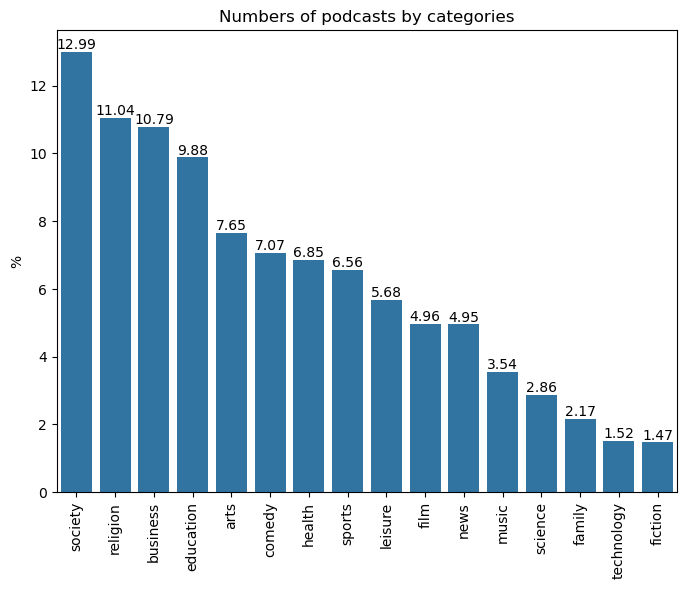

In [36]:
plot_bars(categories_grouped,"percent_of_podcasts","%","Numbers of podcasts by categories")

As there are more categories than podcasts, it was decided to examine the podcasts which are characterised by several categories. Queries from podcasts dataframe by grouping data first by title and then by podcast_id revealed that there are 15 podcasts which have no title (podcasts with no titles are from different categories).

In [37]:
title_by_category = duckdb.sql("""SELECT p.title,
                             COUNT(c.category) AS number_of_categories
                             FROM podcasts p
                             JOIN categories_abstract c
                             ON c.podcast_id = p.podcast_id
                             GROUP BY p.title
                             ORDER BY number_of_categories DESC""").df().drop_duplicates()

title_by_category.iloc[:10,:2]

,title,number_of_categories
0,No Title,15
1,Evolve,9
2,Theatre of the Mind,9
3,Talking Cars (HQ),8
4,We Made It,8
5,Beyond Retirement,8
6,Everything Under The Sun,8
7,FrazerRice.Com,8
8,Am I Doing This Right?,8
9,Pursue Excellence,8


In [38]:
podcast_by_category = duckdb.sql("""SELECT p.podcast_id,
                             COUNT(c.category) AS number_of_categories
                             FROM podcasts p
                             JOIN categories_abstract c
                             ON c.podcast_id = p.podcast_id
                             GROUP BY p.podcast_id
                             ORDER BY number_of_categories DESC""").df().drop_duplicates()

podcast_by_category.iloc[:10,:2]

,podcast_id,number_of_categories
0,fa8c359031380cd4f3b38358c8a75f92,8
1,c4be70db3c16d3607bd7ae4999cb6e86,8
2,be905117ff9b3a13b1a065801241903b,8
3,af4c9ab7e54007e755ed9f063b89a328,7
4,ecec25ae9c94e59eac21abf3bf5c9eef,7
5,b834bcf94406863e8484f4ee1f4d7bdf,7
6,f160109d6eeb3bb70efbc5238bb84485,7
7,b80b40b6b6787935970e5153fdfcfd4c,7
8,cc100f7df19c3e84f03cec568accbfd3,7
9,e1439bd017c13253d1530b3803a8e33e,7


By examining one of the titles with different categories, it can be observed that in some cases there are different podcasts with the same titles (see bellow two different podcast ids of for the title "Evolve"). It can be assumed that there are two different versions of the same podcasts.

In [39]:
category = duckdb.sql("""SELECT 
                            p.podcast_id,
                            p.title,
                            c.category AS category,
                             FROM podcasts p
                             JOIN categories_abstract c
                             ON c.podcast_id = p.podcast_id
                             WHERE p.title = 'Evolve'
                            """).df()

category

,podcast_id,title,category
0,c3552faff5886593e3ff12e281c7ec2d,Evolve,religion
1,c3552faff5886593e3ff12e281c7ec2d,Evolve,society
2,b37a9135097a99f130cea5aef2d47465,Evolve,business
3,b37a9135097a99f130cea5aef2d47465,Evolve,business
4,b37a9135097a99f130cea5aef2d47465,Evolve,education
5,b37a9135097a99f130cea5aef2d47465,Evolve,education
6,b37a9135097a99f130cea5aef2d47465,Evolve,society
7,a45c1c8c8e4cbc1f4e1a33413b1c9763,Evolve,religion
8,a45c1c8c8e4cbc1f4e1a33413b1c9763,Evolve,education


### What are the highest numbers of reviews written for podcasts of different categories?

It was found out that 14.61 % podcast reviews belongs to the 'society' category, 9.75 % to 'business' category and 9,28 % to 'comedy' category. For some categories there are proportionaly more reviews than podcasts and for other categories there are proportionally more podcasts than reviews - for example, although 11.04 % podcasts  are in the 'religion' category, only 6.39 % reviews belong to this category; podcasts in 'comedy' category are proportionally more reviewed.

In [40]:
numbers_of_reviews = duckdb.sql("""SELECT ca.category, COUNT(r.content) AS number_of_reviews
                             FROM reviews r
                             JOIN categories_abstract ca
                             ON r.podcast_id = ca.podcast_id
                             GROUP BY ca.category
                             ORDER BY number_of_reviews DESC""").df()

numbers_of_reviews = numbers_of_reviews.set_index("category")

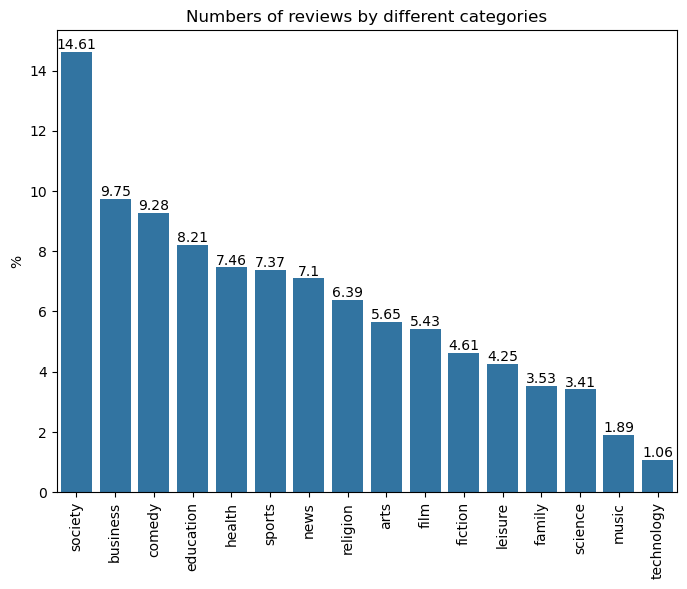

In [41]:
plot_bars((get_percent(numbers_of_reviews)*100).round(2),"number_of_reviews","%", 
          "Numbers of reviews by different categories")

### Which podcasts receive the highest and lowest numbers of reviews?


In order to find out which podcasts received highest and lowest numbers of reviews, the following query was performed. 10 titles of podcasts with highest numbers of reviews are presented in the plot.

In [42]:
podcasts_by_reviews = duckdb.sql("""SELECT 
                        p.title,
                        COUNT(r.content) AS number_of_reviews,
                        AVG(r.rating) AS average_rating
                        FROM podcasts p 
                        JOIN reviews r
                        ON p.podcast_id = r.podcast_id
                        JOIN categories_abstract ca
                        ON p.podcast_id = ca.podcast_id
                        GROUP BY p.title
                        ORDER BY number_of_reviews DESC
                        """).df().drop_duplicates().set_index('title')
podcasts_by_reviews_highest = pd.DataFrame(podcasts_by_reviews["number_of_reviews"].nlargest(10))


In [43]:
podcasts_by_reviews_highest3 = pd.DataFrame(podcasts_by_reviews["number_of_reviews"].nlargest(20))

In [44]:
podcasts_by_reviews_highest3.to_csv("podcasts_by_reviews3.csv")

In [45]:
podcasts_by_reviews_ca = duckdb.sql("""SELECT 
                        p.title,
                        ca.category
                        FROM podcasts p 
                        JOIN categories_abstract ca
                        ON p.podcast_id = ca.podcast_id
                        WHERE p.title = 'Crime Junkie'
                        OR p.title = 'My Favorite Murder with Karen Kilgariff and Georgia Hardstark'
                        OR p.title = 'Wow in the World'
                        """).df()
podcasts_by_reviews_ca

,title,category
0,My Favorite Murder with Karen Kilgariff and Ge...,comedy
1,My Favorite Murder with Karen Kilgariff and Ge...,fiction
2,Wow in the World,education
3,Wow in the World,family
4,Wow in the World,family
5,Crime Junkie,fiction


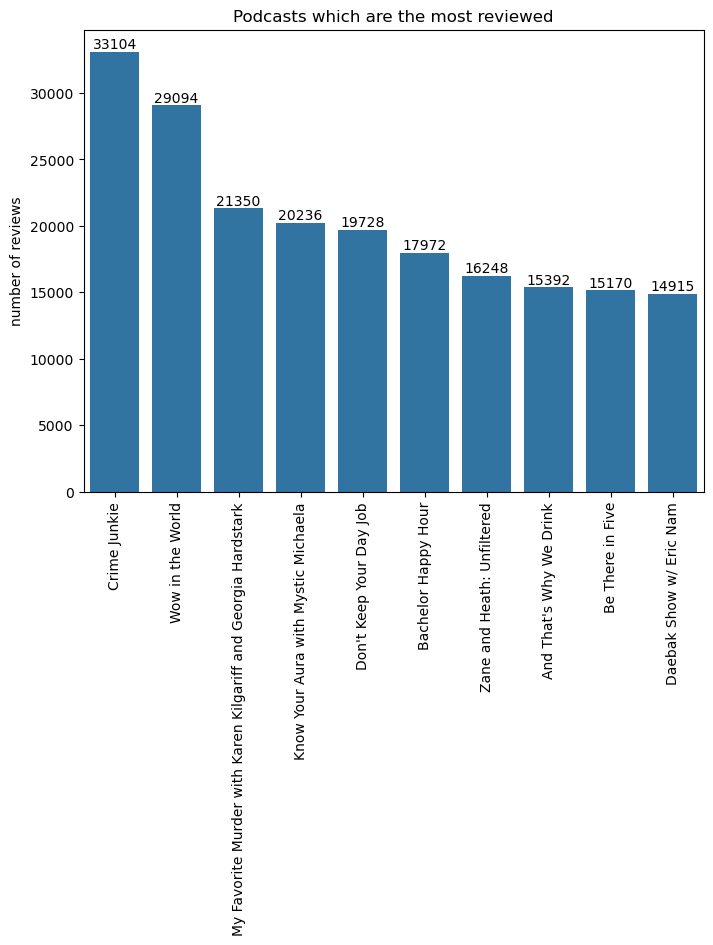

In [46]:
plot_bars(podcasts_by_reviews_highest, "number_of_reviews","number of reviews", 
          "Podcasts which are the most reviewed")


Also podcasts which received just one review were counted. It can be seen that there 15592 podcasts which received just one review.

In [47]:
print(f' {podcasts_by_reviews["number_of_reviews"][podcasts_by_reviews["number_of_reviews"]==1].count()} \
podcasts received just one review.')

 15592 podcasts received just one review.


### Which podcasts receive the best and worst ratings?


In order to find out which podcasts receive the best and the worst ratings, the following query is performed. 

In [48]:
podcasts_by_ratings1 = duckdb.sql("""SELECT 
                        p.title,
                        AVG(r.rating) AS average_rating
                        FROM podcasts p
                         JOIN reviews r 
                        ON p.podcast_id = r.podcast_id
                        GROUP BY p.title
                        ORDER BY average_rating DESC""").df().drop_duplicates().set_index('title')


As quite a high number od podcasts received the highest rating, the number of podcasts with the highest rating is presented bellow. 

In [49]:
print(f' {podcasts_by_ratings1["average_rating"][podcasts_by_ratings1["average_rating"]==5].count()} \
podcasts received maximum average rating 5.')

 83036 podcasts received maximum average rating 5.


Percentage values of ratings for all podcasts were calculated (see bellow). It can be observed that maximum rating 5 is the most widespread assesment of podcasts (almost 87 percent from all reviews were with such a rating).

In [50]:
podcasts_by_ratings_count = duckdb.sql("""SELECT
                        COUNT(CASE WHEN rating = 1 THEN content END) AS rating_1,
                        COUNT(CASE WHEN rating = 2 THEN content END) AS rating_2,
                        COUNT(CASE WHEN rating = 3 THEN content END) AS rating_3,
                        COUNT(CASE WHEN rating = 4 THEN content END) AS rating_4,
                        COUNT(CASE WHEN rating = 5 THEN content END) AS rating_5
                        FROM reviews     
                        """).df()
podcasts_by_ratings_percent = (get_percent(podcasts_by_ratings_count.transpose())*100).round(2)
podcasts_by_ratings_percent.columns = ["percent"]


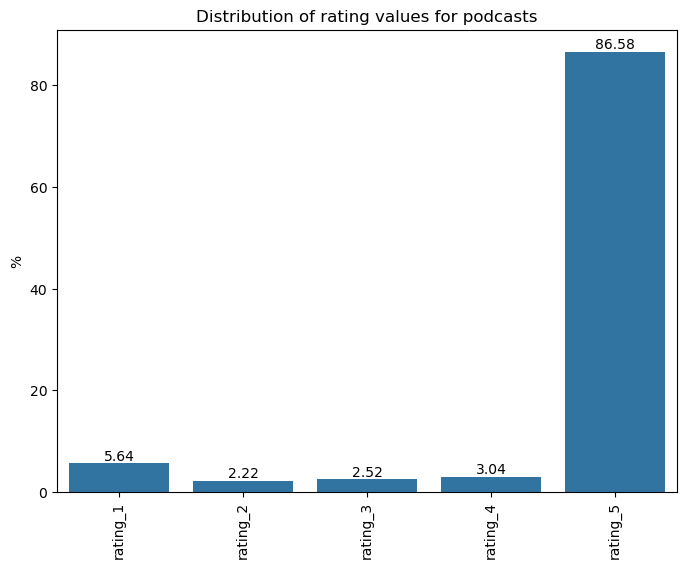

In [51]:
plot_bars(podcasts_by_ratings_percent,"percent","%","Distribution of rating values for podcasts")

### What are differences in ratings of podcasts among podcasts which receive the highest numbers of reviews?


Also, it was checked what the ratings of the most reviewed podcasts are. It can be observed that the most reviewed podcasts are not among the best reviewed podcasts as neither of them receive the maximum average ratings.

In [52]:
podcasts_by_ratings2 = duckdb.sql("""SELECT 
                        p.title,
                        COUNT(r.content) AS number_of_reviews,
                        AVG(r.rating) AS average_rating
                        FROM podcasts p 
                        JOIN reviews r 
                        ON p.podcast_id = r.podcast_id
                        GROUP BY p.title
                        ORDER BY number_of_reviews DESC
                        LIMIT 10""").df().drop_duplicates().set_index('title').round(2)


In [53]:
podcasts_by_ratings2.to_csv("podcasts_by_ratings2.csv")

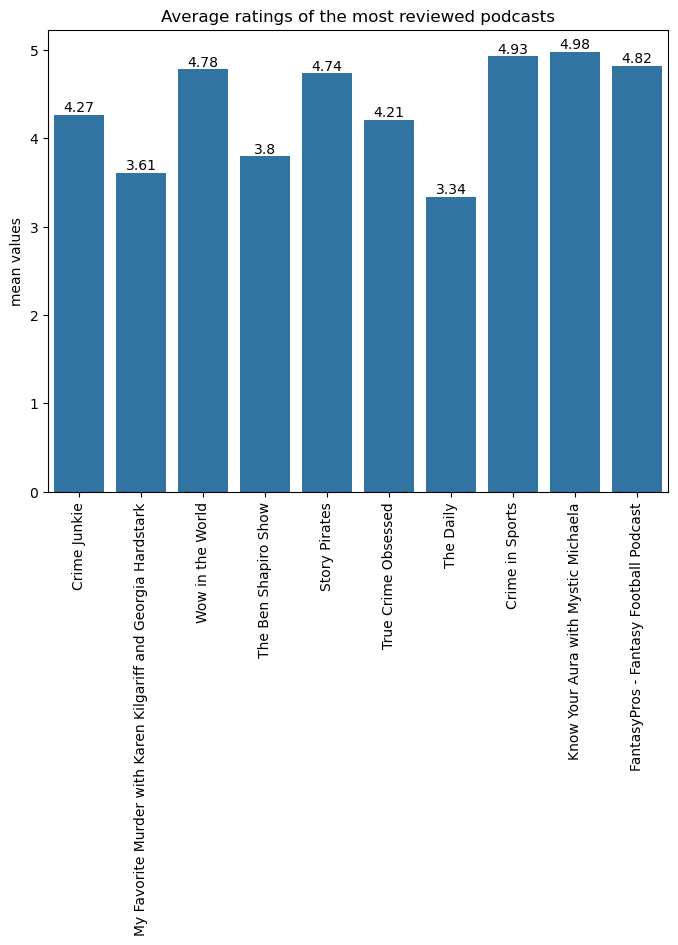

In [54]:
plot_bars(podcasts_by_ratings2, "average_rating","mean values", "Average ratings of the most reviewed podcasts")

### Which podcasts were/are broadcasted for the longest time?

In order to answer the question about the longevity of podcasts, the query was performed by selecting the initial review date, the last review date and calculating the duration of podcast broadcasting (by subtracting initial date from the last date). The query was grouped by the podcast title. It was assumed that the first and the last reviews represent the time when the podcast was first broadcasted and when it ended (although this is not the perfect measure - it is possible that initially some podcasts didnot receive any reviews though they were broadcasted).

In [55]:
podcasts_b = duckdb.sql("""SELECT  
                        p.title,
                        COUNT(r.content) number_of_reviews,
                        AVG(r.rating) as average_rating,
                        MIN(r.created_at) AS first_review_date,
                        MAX(r.created_at) AS last_review_date,
                        EXTRACT(DAY FROM (last_review_date - first_review_date)) AS longevity_of_podcast
                        FROM podcasts p
                        JOIN reviews r
                        ON r.podcast_id = p.podcast_id
                        GROUP BY p.title
                        ORDER BY longevity_of_podcast DESC
                        """).df().drop_duplicates().round(2).set_index("title")
podcast_long = pd.DataFrame(podcasts_b["longevity_of_podcast"].nlargest(10))
podcasts_b.iloc[:10,2:4]

,first_review_date,last_review_date
title,,
All Songs Considered,2005-12-15,2023-02-05
Democracy Now! Audio,2005-12-09,2023-01-25
PotterCast: The Harry Potter Podcast (since 2005),2005-12-21,2023-01-31
Storynory - Audio Stories For Kids,2006-01-05,2023-02-09
Video Game Outsiders,2005-12-15,2023-01-18
NBC Meet the Press,2005-12-19,2023-01-16
Insight for Living Daily Broadcast,2005-12-10,2023-01-06
60 Minutes,2005-12-21,2023-01-10
WSJ Tech News Briefing,2006-01-10,2023-01-27


In [56]:
podcast_long2 = podcasts_b.nlargest(10, "longevity_of_podcast", keep='all')
podcast_long2.to_csv("podcast_longevity.csv")

It can be observed that the broadcasts which were broadcasted for the longest time have been on air since 2005. 

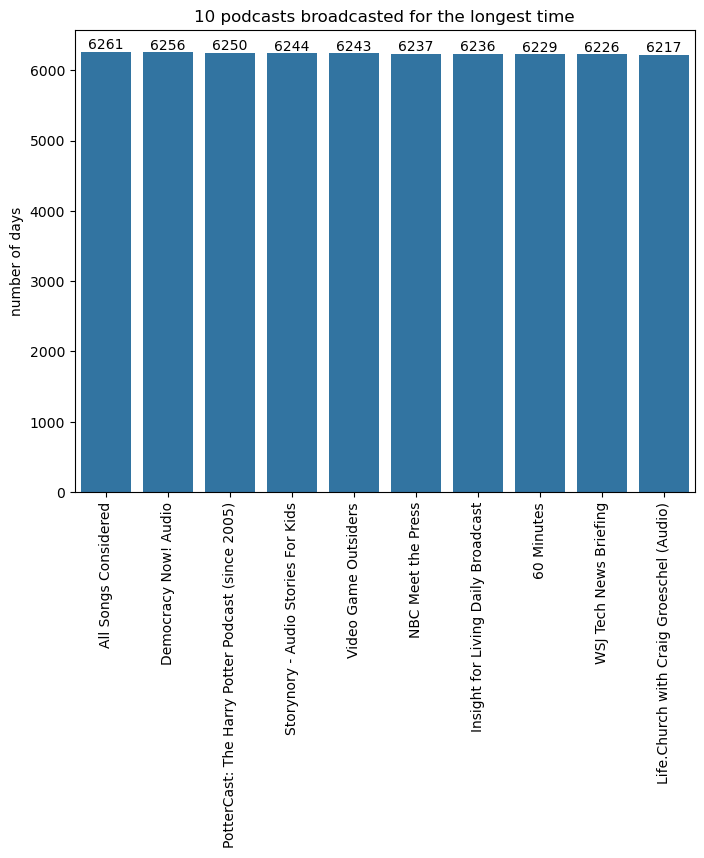

In [57]:
plot_bars(podcast_long, "longevity_of_podcast", "number of days", 
          "10 podcasts broadcasted for the longest time")

It was also examined what the ratings of the podcasts on air for the longest time are. It can be observed that these podcasts do not receive the highest average ratings.

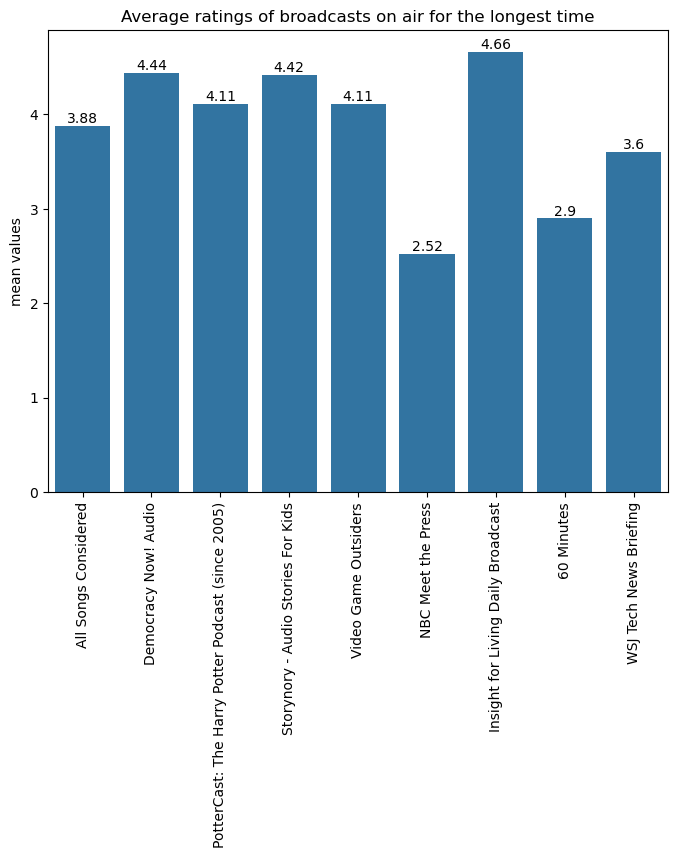

In [58]:

plot_bars(pd.DataFrame(podcasts_b.iloc[:9,1]), "average_rating", "mean values", 
          "Average ratings of broadcasts on air for the longest time")

### What are ratings of podcasts of different categories?


It was examined what are differences in ratings of podcasts by different categories. It can be observed that podcasts on such topics as business, religion and education receive higher ratings while podcasts on such topics as technologies, news and fiction receive lower ratings.

In [59]:
ratings_by_categories = duckdb.sql("""SELECT  
                        ca.category,
                        AVG(r.rating) as average_rating,
                        FROM reviews r
                        JOIN categories_abstract ca
                        ON r.podcast_id = ca.podcast_id
                        GROUP BY ca.category
                        ORDER BY average_rating DESC
                        """).df().drop_duplicates().round(2).set_index("category")


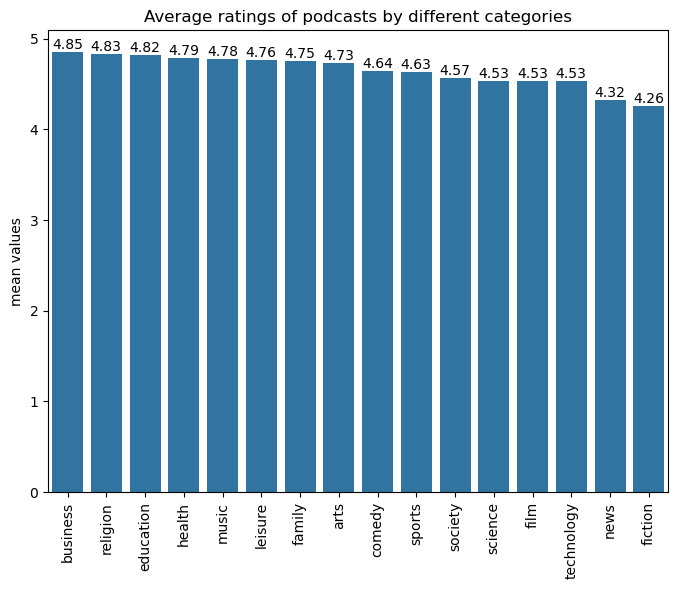

In [60]:
plot_bars(ratings_by_categories, "average_rating", "mean values", 
          "Average ratings of podcasts by different categories")

### What are highest numbers and average ratings of reviews written by a single author?

A query was performed in order to find out what the numbers of reviews written by a single author are and what their ratings are. It can be observed that on the top 10 are the authors who wrote more than 300 reviews and they gave almost maximum ratings to the podcasts they reviewed.

In [61]:
authors = duckdb.sql("""SELECT  
                        COUNT (content) as number_of_reviews,
                        AVG (rating) AS average_rating
                        FROM reviews
                        GROUP BY author_id
                        ORDER BY number_of_reviews DESC
                        """).df().round(2)
authors.sort_values("average_rating", ascending=True)

,number_of_reviews,average_rating
321638,1,1.0
766224,1,1.0
570075,1,1.0
349385,1,1.0
766228,1,1.0
...,...,...
556132,1,5.0
556131,1,5.0
556130,1,5.0
556148,1,5.0


However, the examination of means of numbers of reviews and average ratings revealed that the mean of numbers of reviews per author is quite low. 

In [62]:
print('Mean of the number of reviews per author and avarage rating per author:')
print(authors['number_of_reviews'].mean())
print(authors['average_rating'].mean())

Mean of the number of reviews per author and avarage rating per author:
1.4014437888272435
4.686959861992768


The examination of outliers, kerner density estimation plots, skewness and kurtosis values revealed that the data is highly skewed - there is just a small number of authors who wrote a high number of reviews while a high majority of reviewers wrote a review just once. The average ratings per author data is also skewed though in a lesser degree than numbers of reviews variable. 

In [63]:
print(f' Outliers for numbers of reviews per author:')
find_outliers(authors,0,2)

 Outliers for numbers of reviews per author:
The number of lower outliers is:0,    The number of upper outliers is :275895


In [64]:
print('Outliers for average ratings per author:')
find_outliers(authors,1,2)

Outliers for average ratings per author:
The number of lower outliers is:204207,    The number of upper outliers is :0


Skewness values:

Symmetrical: A distribution can be called symmetric if it appears the same from the left and right from the center point.
Asymmetrical: A distribution can be called asymmetric if it doesn’t appear the same from the left and right from the center point.
Distribution on the basis of skewness value:

Skewness = 0: Then normally distributed.
Skewness > 0: Then more weight in the left tail of the distribution.
Skewness < 0: Then more weight in the right tail of the distribution.

In [65]:
print(f"Skewness for number of reviews: {authors['number_of_reviews'].skew()}")
print(f"Skewness for average ratings: {authors['average_rating'].skew()}")


Skewness for number of reviews: 85.6075476752882
Skewness for average ratings: -3.096522577810678


Kurtosis values:

kurtosis for normal distribution is equal to 3.
For a distribution having kurtosis < 3: It is called playkurtic.
For a distribution having kurtosis > 3, It is called leptokurtic and it signifies that it tries to produce more outliers rather than the normal distribution (see https://www.geeksforgeeks.org/how-to-calculate-skewness-and-kurtosis-in-python/)

In [66]:
print(f"Kurtosis for numbers of reviews: {authors['number_of_reviews'].kurt()}")
print(f"Kurtosis for average ratings: {authors['average_rating'].kurt()}")

Kurtosis for numbers of reviews: 16787.595248270107
Kurtosis for average ratings: 8.604427603535367


<Axes: xlabel='number_of_reviews', ylabel='Count'>

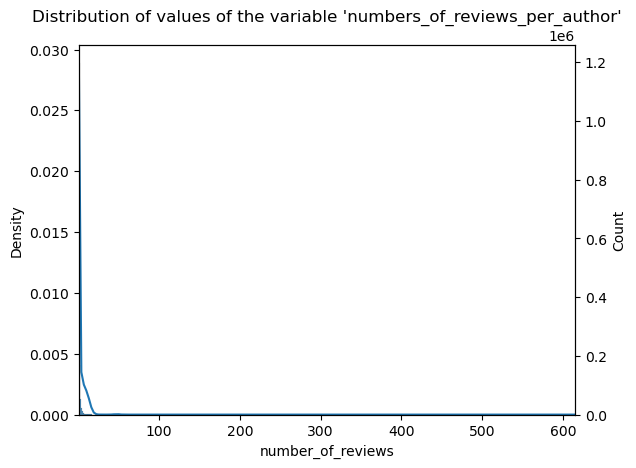

In [67]:
fig, ax1 = plt.subplots()
sns.kdeplot(data=authors, x='number_of_reviews', ax=ax1)
ax1.set_xlim((authors['number_of_reviews'].min(), authors['number_of_reviews'].max()))
ax2 = ax1.twinx()
ax1.set_title("Distribution of values of the variable 'numbers_of_reviews_per_author'")
sns.histplot(data=authors, x='number_of_reviews', discrete=True, ax=ax2)

<Axes: xlabel='average_rating', ylabel='Count'>

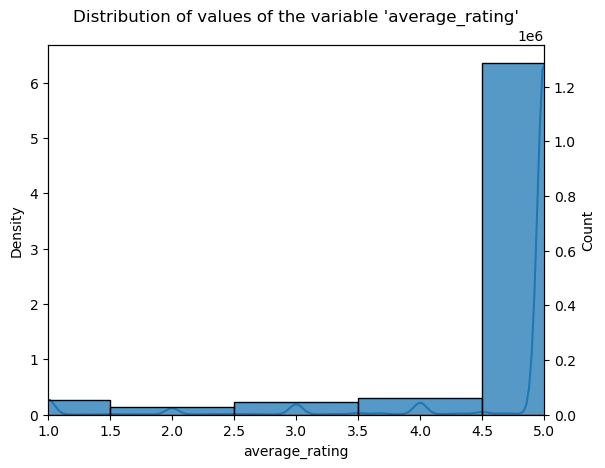

In [68]:
fig, ax1 = plt.subplots()
sns.kdeplot(data=authors, x='average_rating', ax=ax1)
ax1.set_xlim((authors['average_rating'].min(), authors['average_rating'].max()))
ax2 = ax1.twinx()
ax1.set_title("Distribution of values of the variable 'average_rating'")
sns.histplot(data=authors, x='average_rating', discrete=True, ax=ax2)


### Is there a correlation between numbers of reviews and average ratings of reviews written by a single author?

Also, it was examined if there is a correlation between numbers of reviews per author and average ratings per author (that is, if authors who write higher numbers of reviews tend to give higher ratings to podcasts). The correlation analysis revealed that there is no statistically significant relationship between these variables. 

In [69]:
corr, p_value = st.pearsonr(authors['number_of_reviews'], authors['average_rating'])
print (f'Pearson correlation coeficient: {corr}')
print (f'P-value: {p_value}')

Pearson correlation coeficient: -0.042989187957928436
P-value: 0.0


### What are highest numbers of reviews written by a single author for podcasts of different categories?

it was examined how many authors contributed to reviewing for podcasts of different topics. It can be observed that the highest percent of reviewers contributed to podcasts of society, business, comedy and education topics while the topics of science, music and technology were the least popular among reviewers. 

In [70]:
categories_by_authors = duckdb.sql("""SELECT  ca.category,
                        COUNT (r.author_id) AS number_of_authors
                        FROM categories_abstract ca 
                        JOIN reviews r
                        ON ca.podcast_id = r.podcast_id
                        GROUP BY ca.category
                        ORDER BY number_of_authors DESC""").df().drop_duplicates().set_index("category")


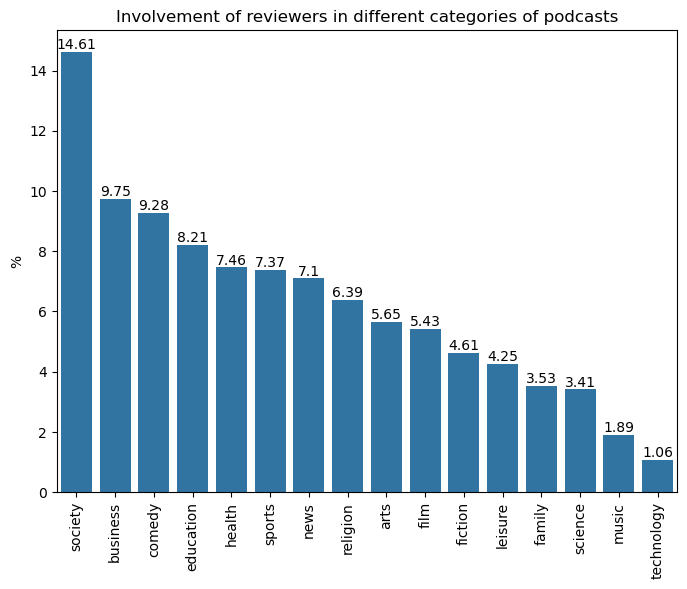

In [71]:
plot_bars((get_percent(categories_by_authors)*100).round(2), "number_of_authors", "%", 
          "Involvement of reviewers in different categories of podcasts")

### How are podcasts of different categories distributed over time?

In order to examine how podcasts of different topics were reviewed over time, a dateframe with time series rows and columns for average ratings of podcasts of different categories was created. The following steps were used: 1. a dataframe was created with time series data as the index with columns including data on average ratings for each category of podcasts; 2. time series data were grouped for the year period; 3.list with color names was created; 4. a time series chart was created with each line corresponding the trends of average ratings in each category of podcasts. The same steps were repeated for numbers of reviews in different categories. 


In [72]:
reviews_grouped = duckdb.sql("""SELECT  
                        r.created_at AS created_at,
                        AVG(CASE WHEN ca.category = 'society' THEN r.rating END) AS 'society',
                        AVG(CASE WHEN ca.category = 'comedy' THEN r.rating END) AS 'comedy',
                        AVG(CASE WHEN ca.category = 'business' THEN r.rating END) AS 'business',
                        AVG(CASE WHEN ca.category = 'education' THEN r.rating END) AS 'education',
                        AVG(CASE WHEN ca.category = 'news' THEN r.rating END) AS 'news',
                        AVG(CASE WHEN ca.category = 'sports' THEN r.rating END) AS 'sports',
                        AVG(CASE WHEN ca.category = 'health' THEN r.rating END) AS 'health',
                        AVG(CASE WHEN ca.category = 'film' THEN r.rating END) AS 'film',
                        AVG(CASE WHEN ca.category = 'fiction' THEN r.rating END) AS 'fiction',
                        AVG(CASE WHEN ca.category = 'arts' THEN r.rating END) AS 'arts',
                        AVG(CASE WHEN ca.category = 'religion' THEN r.rating END) AS 'religion',
                        AVG(CASE WHEN ca.category = 'science' THEN r.rating END) AS 'science',
                        AVG(CASE WHEN ca.category = 'leisure' THEN r.rating END) AS 'leisure',
                        AVG(CASE WHEN ca.category = 'family' THEN r.rating END) AS 'family',
                        AVG(CASE WHEN ca.category = 'music' THEN r.rating END) AS 'music',
                        AVG(CASE WHEN ca.category = 'technology' THEN r.rating END) AS 'technology'
                        FROM reviews r
                        JOIN categories_abstract ca
                        ON ca.podcast_id = r.podcast_id
                        GROUP BY created_at
                        ORDER BY created_at""").df().drop_duplicates().set_index("created_at").round(2)
reviews_grouped = reviews_grouped.groupby(pd.Grouper(freq="Y")).mean().round(2)


In [73]:
reviews_grouped2 = duckdb.sql("""SELECT  
                        r.created_at AS created_at,
                        COUNT(CASE WHEN ca.category = 'society' THEN r.content END) AS 'society',
                        COUNT(CASE WHEN ca.category = 'comedy' THEN r.content END) AS 'comedy',
                        COUNT(CASE WHEN ca.category = 'business' THEN r.content END) AS 'business',
                        COUNT(CASE WHEN ca.category = 'education' THEN r.content END) AS 'education',
                        COUNT(CASE WHEN ca.category = 'news' THEN r.content END) AS 'news',
                        COUNT(CASE WHEN ca.category = 'sports' THEN r.content END) AS 'sports',
                        COUNT(CASE WHEN ca.category = 'health' THEN r.content END) AS 'health',
                        COUNT(CASE WHEN ca.category = 'film' THEN r.content END) AS 'film',
                        COUNT(CASE WHEN ca.category = 'fiction' THEN r.content END) AS 'fiction',
                        COUNT(CASE WHEN ca.category = 'arts' THEN r.content END) AS 'arts',
                        COUNT(CASE WHEN ca.category = 'religion' THEN r.content END) AS 'religion',
                        COUNT(CASE WHEN ca.category = 'science' THEN r.content END) AS 'science',
                        COUNT(CASE WHEN ca.category = 'leisure' THEN r.content END) AS 'leisure',
                        COUNT(CASE WHEN ca.category = 'family' THEN r.content END) AS 'family',
                        COUNT(CASE WHEN ca.category = 'music' THEN r.content END) AS 'music',
                        COUNT(CASE WHEN ca.category = 'technology' THEN r.content END) AS 'technology'
                        FROM reviews r
                        JOIN categories_abstract ca
                        ON ca.podcast_id = r.podcast_id
                        GROUP BY created_at
                        ORDER BY created_at""").df().drop_duplicates().set_index("created_at").round(2)
reviews_grouped2 = reviews_grouped2.groupby(pd.Grouper(freq="Y")).sum().round(2)


In [74]:
reviews_grouped.to_csv('reviews_grouped.csv', index=True)
reviews_grouped2.to_csv('reviews_grouped2.csv', index=True)


In [75]:
colors = ['Red', 'Orange', 'Yellow', 'Green', 'Blue', 'Indigo', 
          'Violet', 'Black', 'Maroon', 'Gray', 'Brown', 'Crimson', 
          'Magenta', 'Cyan','Navy','Lavender']

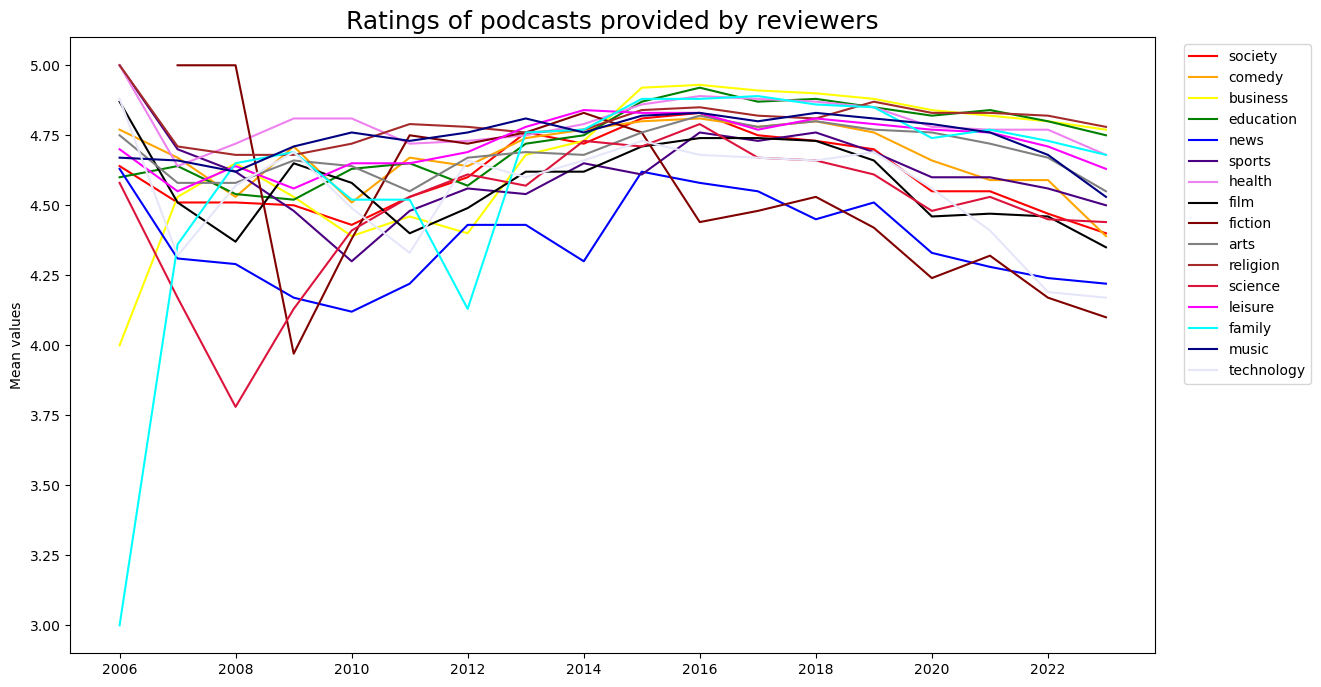

In [76]:
fig, ax = plt.subplots(figsize=(14,8))
ax.plot(reviews_grouped['2005-12-09':'2023-02-16'].index, \
        reviews_grouped.loc['2005-12-09':'2023-02-16','society'],color=colors[0], label = 'society')
ax.plot(reviews_grouped['2005-12-09':'2023-02-16'].index, \
        reviews_grouped.loc['2005-12-09':'2023-02-16','comedy'],color=colors[1], label = 'comedy')
ax.plot(reviews_grouped['2005-12-09':'2023-02-16'].index, \
        reviews_grouped.loc['2005-12-09':'2023-02-16','business'],color=colors[2], label = 'business')
ax.plot(reviews_grouped['2005-12-09':'2023-02-16'].index, \
        reviews_grouped.loc['2005-12-09':'2023-02-16','education'],color=colors[3], label = 'education')
ax.plot(reviews_grouped['2005-12-09':'2023-02-16'].index, \
        reviews_grouped.loc['2005-12-09':'2023-02-16','news'],color=colors[4], label = 'news')
ax.plot(reviews_grouped['2005-12-09':'2023-02-16'].index, \
        reviews_grouped.loc['2005-12-09':'2023-02-16','sports'],color=colors[5], label = 'sports')
ax.plot(reviews_grouped['2005-12-09':'2023-02-16'].index, \
        reviews_grouped.loc['2005-12-09':'2023-02-16','health'],color=colors[6], label = 'health')
ax.plot(reviews_grouped['2005-12-09':'2023-02-16'].index, \
        reviews_grouped.loc['2005-12-09':'2023-02-16','film'],color=colors[7], label = 'film')
ax.plot(reviews_grouped['2005-12-09':'2023-02-16'].index, \
        reviews_grouped.loc['2005-12-09':'2023-02-16','fiction'],color=colors[8], label = 'fiction')
ax.plot(reviews_grouped['2005-12-09':'2023-02-16'].index, \
        reviews_grouped.loc['2005-12-09':'2023-02-16','arts'],color=colors[9], label = 'arts')
ax.plot(reviews_grouped['2005-12-09':'2023-02-16'].index, \
        reviews_grouped.loc['2005-12-09':'2023-02-16','religion'],color=colors[10], label = 'religion')
ax.plot(reviews_grouped['2005-12-09':'2023-02-16'].index, \
        reviews_grouped.loc['2005-12-09':'2023-02-16','science'],color=colors[11], label = 'science')
ax.plot(reviews_grouped['2005-12-09':'2023-02-16'].index, \
        reviews_grouped.loc['2005-12-09':'2023-02-16','leisure'],color=colors[12], label = 'leisure')
ax.plot(reviews_grouped['2005-12-09':'2023-02-16'].index, \
        reviews_grouped.loc['2005-12-09':'2023-02-16','family'],color=colors[13], label = 'family')
ax.plot(reviews_grouped['2005-12-09':'2023-02-16'].index, \
        reviews_grouped.loc['2005-12-09':'2023-02-16','music'],color=colors[14], label = 'music')
ax.plot(reviews_grouped['2005-12-09':'2023-02-16'].index, \
        reviews_grouped.loc['2005-12-09':'2023-02-16','technology'],color=colors[15], label = 'technology')
plt.legend(bbox_to_anchor=(1.02, 1))


#ax.add_artist(legend)
ax.set_ylabel('Mean values')
ax.set_title('Ratings of podcasts provided by reviewers', size=18)
plt.show()

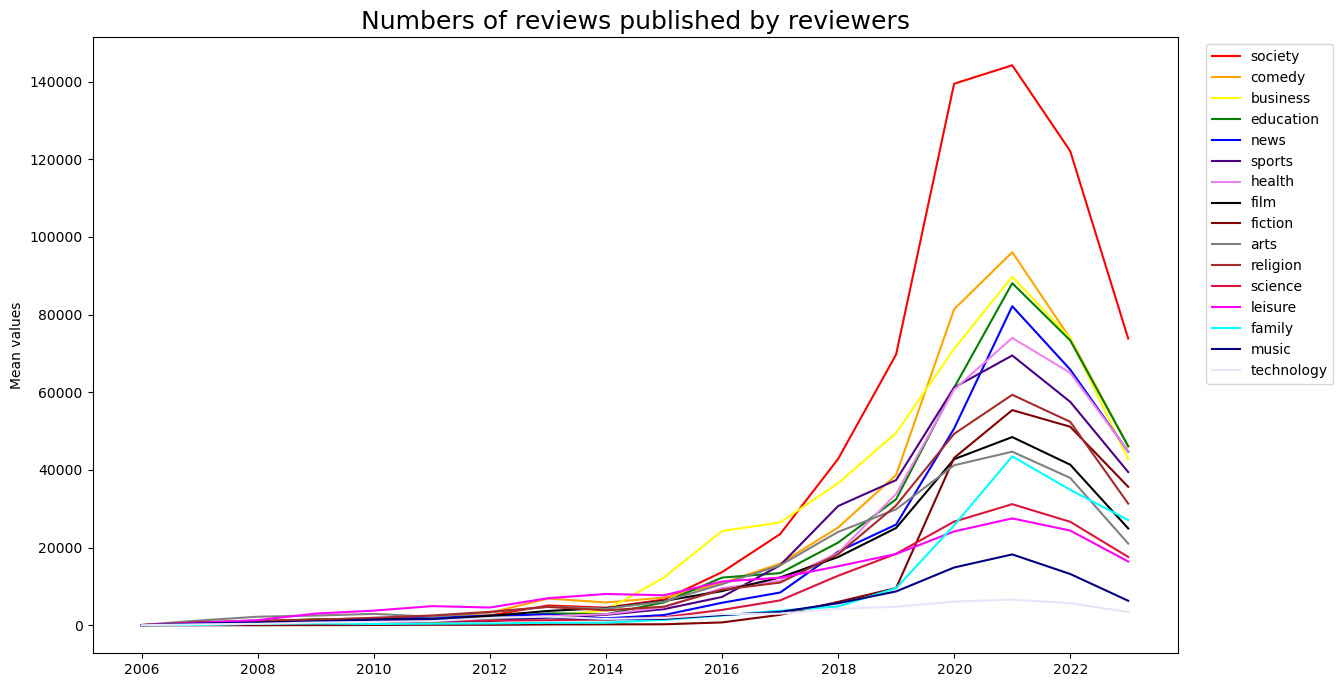

In [77]:
fig, ax = plt.subplots(figsize=(14,8))
ax.plot(reviews_grouped2['2005-12-09':'2023-02-16'].index, \
        reviews_grouped2.loc['2005-12-09':'2023-02-16','society'],color=colors[0], label = 'society')
ax.plot(reviews_grouped2['2005-12-09':'2023-02-16'].index, \
        reviews_grouped2.loc['2005-12-09':'2023-02-16','comedy'],color=colors[1], label = 'comedy')
ax.plot(reviews_grouped2['2005-12-09':'2023-02-16'].index, \
        reviews_grouped2.loc['2005-12-09':'2023-02-16','business'],color=colors[2], label = 'business')
ax.plot(reviews_grouped2['2005-12-09':'2023-02-16'].index, \
        reviews_grouped2.loc['2005-12-09':'2023-02-16','education'],color=colors[3], label = 'education')
ax.plot(reviews_grouped2['2005-12-09':'2023-02-16'].index, \
        reviews_grouped2.loc['2005-12-09':'2023-02-16','news'],color=colors[4], label = 'news')
ax.plot(reviews_grouped2['2005-12-09':'2023-02-16'].index, \
        reviews_grouped2.loc['2005-12-09':'2023-02-16','sports'],color=colors[5], label = 'sports')
ax.plot(reviews_grouped2['2005-12-09':'2023-02-16'].index, \
        reviews_grouped2.loc['2005-12-09':'2023-02-16','health'],color=colors[6], label = 'health')
ax.plot(reviews_grouped2['2005-12-09':'2023-02-16'].index, \
        reviews_grouped2.loc['2005-12-09':'2023-02-16','film'],color=colors[7], label = 'film')
ax.plot(reviews_grouped2['2005-12-09':'2023-02-16'].index, \
        reviews_grouped2.loc['2005-12-09':'2023-02-16','fiction'],color=colors[8], label = 'fiction')
ax.plot(reviews_grouped2['2005-12-09':'2023-02-16'].index, \
        reviews_grouped2.loc['2005-12-09':'2023-02-16','arts'],color=colors[9], label = 'arts')
ax.plot(reviews_grouped2['2005-12-09':'2023-02-16'].index, \
        reviews_grouped2.loc['2005-12-09':'2023-02-16','religion'],color=colors[10], label = 'religion')
ax.plot(reviews_grouped2['2005-12-09':'2023-02-16'].index, \
        reviews_grouped2.loc['2005-12-09':'2023-02-16','science'],color=colors[11], label = 'science')
ax.plot(reviews_grouped2['2005-12-09':'2023-02-16'].index, \
        reviews_grouped2.loc['2005-12-09':'2023-02-16','leisure'],color=colors[12], label = 'leisure')
ax.plot(reviews_grouped2['2005-12-09':'2023-02-16'].index, \
        reviews_grouped2.loc['2005-12-09':'2023-02-16','family'],color=colors[13], label = 'family')
ax.plot(reviews_grouped2['2005-12-09':'2023-02-16'].index, \
        reviews_grouped2.loc['2005-12-09':'2023-02-16','music'],color=colors[14], label = 'music')
ax.plot(reviews_grouped2['2005-12-09':'2023-02-16'].index, \
        reviews_grouped2.loc['2005-12-09':'2023-02-16','technology'],color=colors[15], label = 'technology')
plt.legend(bbox_to_anchor=(1.02, 1))


#ax.add_artist(legend)
ax.set_ylabel('Mean values')
ax.set_title('Numbers of reviews published by reviewers', size=18)
plt.show()

It can be observed from the plots that average ratings of podcasts on such topics as news and business were lower in the time of economic crisis (years 2009 - 2012) comparing to average ratings in the following years. For such topics as religion and fiction average ratings were higher in the time of economic crisis, then ratings gradualy decreased in the following years. 

What concerns the numbers of reviews, it can be observed that numbers of reviews in all categories started to exponentially increase since 2016, however, the numbers decreased since the year 2022.


## Analysing samples from the data

In this part the analysis of data sampled from the Podcast Reviews dataset will be provided and statistical inferences will made by applying statistical inference procedures. Random samples (n = 1000) were taken from the dataframe "reviews_full" (by using pandas function "sample") which was formed by joining data from the 'reviews' dataframe and data on categories of podcasts from the 'categories_abstract" data (in total there are 2976673 entries in the "reviews_full" dataframe). 

Also, sentiment analysis on the column "content" of the samples was performed based on the pretrained model Distilbert (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english). New columns "label" (giving a label for the review's content either "POSITIVE" or NEGATIVE") and "score" (measuring strongness of the labeling in the scale from 0 to 1) were added to the sample dataframes.

Procedures of random sampling, sentiment analysis, and merging columns into sample dataframes were prescribed in the function "sample_reviews_sentiments" (see the part on functions).

Samples were taken for different periods (to test if there are statistical differences of rewiews' labeling in different time periods) and different categories in order to answer research questions (to test if there are statistical differences of rewiews' labeling in different categories of podcasts).

In [74]:
reviews_full = duckdb.sql("""SELECT  r.*,
                        ca.category
                        FROM reviews r
                        JOIN categories_abstract ca
                        ON ca.podcast_id = r.podcast_id
                        """).df().drop_duplicates()
reviews_full.head()

,podcast_id,title,content,rating,author_id,created_at,category
0,be14fa0e57555c450920fc4432f07885,My go to podcast.,This podcast has it all. Robin does amazing re...,5,487823468B47E3A,2019-02-27,fiction
1,be14fa0e57555c450920fc4432f07885,It’s ok,"It’s a well produced, well researched podcast ...",2,003B8A507164351,2019-02-09,fiction
2,be14fa0e57555c450920fc4432f07885,ANNOYING MUSIC,I would give this podcast a higher star rating...,1,3D210BA63480A8D,2018-11-06,fiction
3,be14fa0e57555c450920fc4432f07885,Interesting!,Recently listened to the latest podcast and ha...,5,EACE6FBF7998573,2017-12-28,fiction
4,be14fa0e57555c450920fc4432f07885,Love this show!,It’s like Unsolved Mysteries podcast edition a...,5,EF4DF5376AA0574,2018-08-01,fiction


In [75]:
reviews_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2976673 entries, 0 to 4529481
Data columns (total 7 columns):
 #   Column      Dtype         
---  ------      -----         
 0   podcast_id  object        
 1   title       object        
 2   content     object        
 3   rating      int64         
 4   author_id   object        
 5   created_at  datetime64[ns]
 6   category    object        
dtypes: datetime64[ns](1), int64(1), object(5)
memory usage: 181.7+ MB


In [76]:
sentiment_pipeline = pipeline("sentiment-analysis")


No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


### Are there significant differences among reviews' sentiments in different time periods?

#### Sampling and sentiment analysis:

Samples were randomly taken from reviews' data for different time periods: 2005 - 2009, 2010 - 2012, 2013 - 2016, 2017 - 2020, 2020 - 2023. The distinction of these time periods gave an opportunity to take into account important events of economic development in the world: 1. pre-crisis growth, 2. economic crisis, 3. post-crisis recovery, 4. post-crisis economic growth, 5. pandemic crisis. 

Five separate samples of 1000 were taken from the data for these periods and sentiment analysis of reviews was performed for reviews in these samples. 

In [77]:
reviews_s1 = sample_reviews_sentiments(reviews_full\
[reviews_full["created_at"]<"2010-01-01"], 1000)
reviews_s2 = sample_reviews_sentiments(reviews_full\
[(reviews_full["created_at"]>="2010-01-01") & (reviews_full["created_at"]<"2012-01-01")], 1000)
reviews_s3 = sample_reviews_sentiments(reviews_full\
[(reviews_full["created_at"]>="2012-01-01") & (reviews_full["created_at"]<"2016-01-01")], 1000)


In [78]:
reviews_s4 = sample_reviews_sentiments(reviews_full\
[(reviews_full["created_at"]>="2016-01-01") & (reviews_full["created_at"]<"2020-01-01")], 1000)
reviews_s5 = sample_reviews_sentiments(reviews_full\
[reviews_full["created_at"]>="2020-01-01"], 1000)

Data on numbers of positive and negative comments in these samples were combined into a new dataframe, percentage values of those numbers were calculated and plotted with a stacked bar plot.

In [79]:
reviews_s_grouped = duckdb.sql("""SELECT 
                        CASE WHEN CAST(created_at AS Date) < '2010-01-01' THEN '2005 - 2009' END AS time_periods,
                        COUNT(CASE WHEN label = 'POSITIVE' THEN label END) AS number_of_positives,
                        COUNT(CASE WHEN label = 'NEGATIVE' THEN label END) AS number_of_negatives
                        FROM reviews_s1
                        GROUP BY time_periods
                        UNION
                        SELECT CASE WHEN CAST(created_at AS Date) >= '2010-01-01' 
                        AND CAST(created_at AS Date) < '2012-01-01' 
                        THEN '2010 - 2012' END AS time_periods,
                        COUNT(CASE WHEN label = 'POSITIVE' THEN label END) AS number_of_positives,
                        COUNT(CASE WHEN label = 'NEGATIVE' THEN label END) AS number_of_negatives
                        FROM reviews_s2
                        GROUP BY time_periods
                        UNION
                        SELECT
                        CASE WHEN CAST(created_at AS Date) >= '2012-01-01' 
                        AND CAST(created_at AS Date) < '2016-01-01'  THEN '2013 - 2016' 
                        END AS time_periods,
                        COUNT(CASE WHEN label = 'POSITIVE' THEN label END) AS number_of_positives,
                        COUNT(CASE WHEN label = 'NEGATIVE' THEN label END) AS number_of_negatives
                        FROM reviews_s3
                        GROUP BY time_periods
                        UNION
                        SELECT 
                        CASE WHEN CAST(created_at AS Date) >= '2016-01-01' 
                        AND CAST(created_at AS Date) < '2020-01-01' THEN '2017 - 2019' 
                        END AS time_periods,
                        COUNT(CASE WHEN label = 'POSITIVE' THEN label END) AS number_of_positives,
                        COUNT(CASE WHEN label = 'NEGATIVE' THEN label END) AS number_of_negatives
                        FROM reviews_s4
                        GROUP BY time_periods
                        UNION
                        SELECT
                        CASE WHEN  CAST(created_at AS Date) >=  '2020-01-01' THEN '2020 - 2023' END AS time_periods,
                        COUNT(CASE WHEN label = 'POSITIVE' THEN label END) AS number_of_positives,
                        COUNT(CASE WHEN label = 'NEGATIVE' THEN label END) AS number_of_negatives
                        FROM reviews_s5
                        GROUP BY time_periods
                        """).df().drop_duplicates().set_index("time_periods")


In [80]:
reviews_s1_grouped_percent = (get_percent(reviews_s_grouped.transpose())*100).round(2)
reviews_s1_grouped_percent = reviews_s1_grouped_percent.transpose().\
sort_values("number_of_positives", ascending=False)


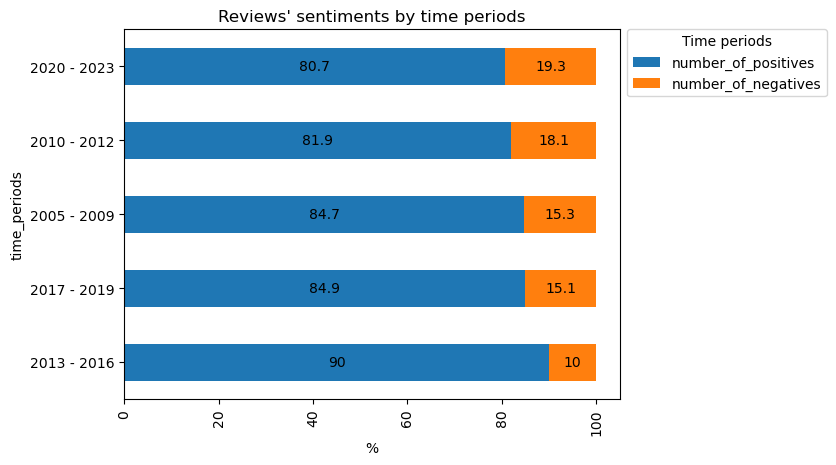

In [81]:
stacked_bars(reviews_s1_grouped_percent, "Time periods", "Reviews' sentiments by time periods")

I can be observed from the plot that the lowest number of positive reviews is associated with the economic crisis periods (2010 - 2012) and (2020 - 2023). It could be assumed that economic and health difficulties, pandemic restrictions and political tensions (the war in the Ukraine, etc.) negatively affected the psychological climate of the world population and it got expressed in the less positive podcast reviews. 

A number of statistical test were conducted to test the statistical significance of this inference.

#### Chi square test:

Pearson Chi-square test of association between categorical variables was conducted. The test confirmed that the variables 'number of positive/negative reviews" and "time periods" are dependent (p<0.0001), that is, there is a relationship between reviews' sentiments and time periods. 

In [82]:
chi_square_test(reviews_s_grouped)

Pearson chi square test:39.297

P_value: 0.0
Dependent (reject H0)


#### Permutation test:

Next, permutation test between samples for different time periods was conducted by following steps (they are included in the function "permutation_test_period":
- the difference between observed sample values of numbers of positive sentiments (absolute value) was calculated;
- samples were mixed;
- the combined sample was shuffled and splitted in two equal parts;
- the difference between values of numbers of positive sentiments was calculated;
- the shuffling, splitting and calculating of sample differences was repeated 10000 times;
- calculated differences (absolute values) were saved into a separate list;
- it was checked how many times the calculated differences from shuffled and splitted samples were higher than the observed difference of values in the initial samples; 
- p-value as the ratio between the number of times when the differences of shuffled and splitted samples were higher than the difference of observed values and the number of permutations (10000).


In [83]:
permutation_test_period(reviews_s1, reviews_s2, 'label',reviews_s_grouped.sort_index().index, 0, 1)
permutation_test_period(reviews_s1, reviews_s3, 'label',reviews_s_grouped.sort_index().index, 0, 2)
permutation_test_period(reviews_s1, reviews_s4, 'label',reviews_s_grouped.sort_index().index, 0, 3)
permutation_test_period(reviews_s1, reviews_s5, 'label',reviews_s_grouped.sort_index().index, 0, 4)
permutation_test_period(reviews_s2, reviews_s3, 'label',reviews_s_grouped.sort_index().index, 1, 2)
permutation_test_period(reviews_s2, reviews_s4, 'label',reviews_s_grouped.sort_index().index, 1, 3)
permutation_test_period(reviews_s2, reviews_s5, 'label',reviews_s_grouped.sort_index().index, 1, 4)
permutation_test_period(reviews_s3, reviews_s4, 'label',reviews_s_grouped.sort_index().index, 2, 3)
permutation_test_period(reviews_s3, reviews_s5, 'label',reviews_s_grouped.sort_index().index, 2, 4)
permutation_test_period(reviews_s4, reviews_s5, 'label',reviews_s_grouped.sort_index().index, 3, 4)


Hypothesis H0 that samples <2005 - 2009> and <2010 - 2012> are from the same distribution is approved.
p_value: 0.1049

Hypothesis H0 that samples <2005 - 2009> and <2013 - 2016> are from the same distribution is not approved.
 The alternative hypothesis holds.
p_value: 0.0004

Hypothesis H0 that samples <2005 - 2009> and <2017 - 2019> are from the same distribution is approved.
p_value: 0.9515

Hypothesis H0 that samples <2005 - 2009> and <2020 - 2023> are from the same distribution is not approved.
 The alternative hypothesis holds.
p_value: 0.0209

Hypothesis H0 that samples <2010 - 2012> and <2013 - 2016> are from the same distribution is not approved.
 The alternative hypothesis holds.
p_value: 0.0

Hypothesis H0 that samples <2010 - 2012> and <2017 - 2019> are from the same distribution is approved.
p_value: 0.0848

Hypothesis H0 that samples <2010 - 2012> and <2020 - 2023> are from the same distribution is approved.
p_value: 0.5321

Hypothesis H0 that samples <2013 - 2016> and <

It can be observed that null hypotheses that samples were taken from the same distribution were not approved for these time periods:
 - 
 - 2005 - 2009 and 2010 - 2012;
 - 2005 - 2009 and 2013 - 2016;
 - 2010 - 2012 and 2013 - 2016;
 - 2010 - 2012 and 2017 - 2019;
 - 2013 - 2016 and 2017 - 2019;
 - 2013 - 2016 and 2020 - 2023.
 
 

This confirms the hypothesis that times of economic, political or other crises affects the sentiments expressed in the podcasts' reviews. 

#### Confidence intervals:

Also, the relationship between review sentiments and time periods was measured by calculating confidence intervals of sample values and differences between sample values. Confidence intervals for confidence level 95 % were calculated by the following steps:
- proportions of positive sentiments in both samples were calculated;
- lower and upper values of confidence intervals were calculated (by getting differences of proportions and adding or dividing standard errors multiplied by z value for the specific confidence level);
- it was checked if the confidence intervals include 0 (if yes,  it is unlikely that there is  a true difference in proportions of positive sentiments for different time periods).


In [84]:
confidence_interval_proportion_period(reviews_s1,'label','POSITIVE',reviews_s_grouped.sort_index().index, 0)
confidence_interval_proportion_period(reviews_s1,'label','POSITIVE',reviews_s_grouped.sort_index().index, 1)
confidence_interval_proportion_period(reviews_s1,'label','POSITIVE',reviews_s_grouped.sort_index().index, 2)
confidence_interval_proportion_period(reviews_s1,'label','POSITIVE',reviews_s_grouped.sort_index().index, 3)
confidence_interval_proportion_period(reviews_s1,'label','POSITIVE',reviews_s_grouped.sort_index().index, 3)

Confidence intervals for number of positives in the <label> variable of <2005 - 2009> sample: 
(0.824688153594277, 0.8693118464057229)
Confidence intervals for number of positives in the <label> variable of <2010 - 2012> sample: 
(0.824688153594277, 0.8693118464057229)
Confidence intervals for number of positives in the <label> variable of <2013 - 2016> sample: 
(0.824688153594277, 0.8693118464057229)
Confidence intervals for number of positives in the <label> variable of <2017 - 2019> sample: 
(0.824688153594277, 0.8693118464057229)
Confidence intervals for number of positives in the <label> variable of <2017 - 2019> sample: 
(0.824688153594277, 0.8693118464057229)


In [85]:
confidence_intervals_difference_period(reviews_s1,reviews_s2, 1000, 'label',
                                       'POSITIVE',reviews_s_grouped.sort_index().index, 0, 1, 0.95)
confidence_intervals_difference_period(reviews_s1,reviews_s3, 1000, 'label',
                                       'POSITIVE',reviews_s_grouped.sort_index().index, 0, 2, 0.95)
confidence_intervals_difference_period(reviews_s1,reviews_s4, 1000, 'label',
                                       'POSITIVE',reviews_s_grouped.sort_index().index, 0, 3, 0.95)
confidence_intervals_difference_period(reviews_s1,reviews_s5, 1000, 'label',
                                       'POSITIVE',reviews_s_grouped.sort_index().index, 0, 4, 0.95)
confidence_intervals_difference_period(reviews_s2,reviews_s3, 1000, 'label',
                                       'POSITIVE',reviews_s_grouped.sort_index().index, 1, 2, 0.95)
confidence_intervals_difference_period(reviews_s2,reviews_s4, 1000, 'label',
                                       'POSITIVE',reviews_s_grouped.sort_index().index, 1, 3, 0.95)
confidence_intervals_difference_period(reviews_s2,reviews_s5, 1000, 'label',
                                       'POSITIVE',reviews_s_grouped.sort_index().index, 1, 4, 0.95)
confidence_intervals_difference_period(reviews_s3,reviews_s4, 1000, 'label',
                                       'POSITIVE',reviews_s_grouped.sort_index().index, 2, 3, 0.95)
confidence_intervals_difference_period(reviews_s3,reviews_s5, 1000, 'label',
                                       'POSITIVE',reviews_s_grouped.sort_index().index, 2, 4, 0.95)
confidence_intervals_difference_period(reviews_s4,reviews_s5, 1000, 'label',
                                       'POSITIVE',reviews_s_grouped.sort_index().index, 3, 4, 0.95)

There is a 95.0 % chance that the confidence interval of (-0.005, 0.061) contains the true difference 
in the proportion of POSITIVE sentiments between reviews 
for podcasts in <2005 - 2009> and <2010 - 2012> time periods.

Since this interval contains the value “0” it means that it’s unlikely 
that there is a true difference in the proportion of POSITIVE sentiments between reviews for podcasts 
 in <2005 - 2009> and <2010 - 2012> time periods.

There is a 95.0 % chance that the confidence interval of (-0.082, -0.024) contains the true difference 
in the proportion of POSITIVE sentiments between reviews 
for podcasts in <2005 - 2009> and <2013 - 2016> time periods.

Since this interval does not contain the value “0” it means 
that it’s highly likely that there is a true difference in the proportion 
of POSITIVE sentiments between reviews for podcasts 
 in <2005 - 2009> and <2013 - 2016> time periods.

There is a 95.0 % chance that the confidence interval of (-0.033, 0.029) contains the

It was found that for the following time periods there is 95 % chance that there is the true difference in the proportion of POSITIVE sentiments of reviews for podcasts:
- 2005 - 2009 and 2010 - 2012;
- 2005 - 2009 and 2013 - 2016;
- 2010 - 2012 and 2013 - 2016;
- 2010 - 2012 and 2017 - 2019;
- 2013 - 2016 and 2017 - 2019;
- 2013 - 2016 and 2020 - 2023.

It can be seen that these are same periods for which permutation test results indicated the independence of samples. It proves that functions for permutation tests and confidence intervals of sample differences calculation are made correctly.

### Are there differences among reviews' sentiments for different categories of podcasts?

The identical calculations were performed in order to test if there are statistically significant differences between reviews' sentments for different podcast categories. Samples of 1000 were taken and sentiment analysis was performed for each podcast category (16 in total). 

In [101]:
l = ["society", 'comedy', 'business','education','news', 'sports', 'health','film',
 'fiction','arts', 'religion', 'science', 'leisure', 'family', 'music', 'technology']

In [102]:
reviews_cs0 = sample_reviews_sentiments(reviews_full[reviews_full["category"]==l[0]], 1000)
reviews_cs1 = sample_reviews_sentiments(reviews_full[reviews_full["category"]==l[1]], 1000)
reviews_cs2 = sample_reviews_sentiments(reviews_full[reviews_full["category"]==l[2]], 1000)

In [103]:
reviews_cs3 = sample_reviews_sentiments(reviews_full[reviews_full["category"]==l[3]], 1000)
reviews_cs4 = sample_reviews_sentiments(reviews_full[reviews_full["category"]==l[4]], 1000)
reviews_cs5 = sample_reviews_sentiments(reviews_full[reviews_full["category"]==l[5]], 1000)

In [104]:
reviews_cs6 = sample_reviews_sentiments(reviews_full[reviews_full["category"]==l[6]], 1000)
reviews_cs7 = sample_reviews_sentiments(reviews_full[reviews_full["category"]==l[7]], 1000)
reviews_cs8 = sample_reviews_sentiments(reviews_full[reviews_full["category"]==l[8]], 1000)

In [105]:
reviews_cs9 = sample_reviews_sentiments(reviews_full[reviews_full["category"]==l[9]], 1000)
reviews_cs10 = sample_reviews_sentiments(reviews_full[reviews_full["category"]==l[10]], 1000)
reviews_cs11 = sample_reviews_sentiments(reviews_full[reviews_full["category"]==l[11]], 1000)

In [106]:
reviews_cs12 = sample_reviews_sentiments(reviews_full[reviews_full["category"]==l[12]], 1000)
reviews_cs13 = sample_reviews_sentiments(reviews_full[reviews_full["category"]==l[13]], 1000)


In [107]:
reviews_cs14 = sample_reviews_sentiments(reviews_full[reviews_full["category"]==l[14]], 1000)
reviews_cs15 = sample_reviews_sentiments(reviews_full[reviews_full["category"]==l[15]], 1000)

Data from samples on numbers of positive and negative sentiments were combined into a single dataframe. 

In [108]:
reviews_s2_grouped = duckdb.sql("""SELECT
                        category,
                        COUNT(CASE WHEN label = 'POSITIVE' THEN label END) AS number_of_positives,
                        COUNT(CASE WHEN label = 'NEGATIVE' THEN label END) AS number_of_negatives,
                        FROM reviews_cs0
                        GROUP BY category
                        UNION  
                        SELECT category,
                        COUNT(CASE WHEN label = 'POSITIVE' THEN label END) AS number_of_positives,
                        COUNT(CASE WHEN label = 'NEGATIVE' THEN label END) AS number_of_negatives,
                        FROM reviews_cs1
                        GROUP BY category
                        UNION
                        SELECT category,
                        COUNT(CASE WHEN label = 'POSITIVE' THEN label END) AS number_of_positives,
                        COUNT(CASE WHEN label = 'NEGATIVE' THEN label END) AS number_of_negatives,
                        FROM reviews_cs2
                        GROUP BY category
                        UNION
                        SELECT category,
                        COUNT(CASE WHEN label = 'POSITIVE' THEN label END) AS number_of_positives,
                        COUNT(CASE WHEN label = 'NEGATIVE' THEN label END) AS number_of_negatives,
                        FROM reviews_cs3
                        GROUP BY category
                        UNION
                        SELECT category,
                        COUNT(CASE WHEN label = 'POSITIVE' THEN label END) AS number_of_positives,
                        COUNT(CASE WHEN label = 'NEGATIVE' THEN label END) AS number_of_negatives,
                        FROM reviews_cs4
                        GROUP BY category
                        UNION
                        SELECT category,
                        COUNT(CASE WHEN label = 'POSITIVE' THEN label END) AS number_of_positives,
                        COUNT(CASE WHEN label = 'NEGATIVE' THEN label END) AS number_of_negatives,
                        FROM reviews_cs5
                        GROUP BY category
                        UNION
                        SELECT category,
                        COUNT(CASE WHEN label = 'POSITIVE' THEN label END) AS number_of_positives,
                        COUNT(CASE WHEN label = 'NEGATIVE' THEN label END) AS number_of_negatives,
                        FROM reviews_cs6
                        GROUP BY category
                        UNION
                        SELECT category,
                        COUNT(CASE WHEN label = 'POSITIVE' THEN label END) AS number_of_positives,
                        COUNT(CASE WHEN label = 'NEGATIVE' THEN label END) AS number_of_negatives,
                        FROM reviews_cs7
                        GROUP BY category
                        UNION
                        SELECT category,
                        COUNT(CASE WHEN label = 'POSITIVE' THEN label END) AS number_of_positives,
                        COUNT(CASE WHEN label = 'NEGATIVE' THEN label END) AS number_of_negatives,
                        FROM reviews_cs8
                        GROUP BY category
                        UNION
                        SELECT category,
                        COUNT(CASE WHEN label = 'POSITIVE' THEN label END) AS number_of_positives,
                        COUNT(CASE WHEN label = 'NEGATIVE' THEN label END) AS number_of_negatives,
                        FROM reviews_cs9
                        GROUP BY category
                        UNION
                        SELECT category,
                        COUNT(CASE WHEN label = 'POSITIVE' THEN label END) AS number_of_positives,
                        COUNT(CASE WHEN label = 'NEGATIVE' THEN label END) AS number_of_negatives,
                        FROM reviews_cs10
                        GROUP BY category
                        UNION
                        SELECT category,
                        COUNT(CASE WHEN label = 'POSITIVE' THEN label END) AS number_of_positives,
                        COUNT(CASE WHEN label = 'NEGATIVE' THEN label END) AS number_of_negatives,
                        FROM reviews_cs11
                        GROUP BY category
                        UNION
                        SELECT category,
                        COUNT(CASE WHEN label = 'POSITIVE' THEN label END) AS number_of_positives,
                        COUNT(CASE WHEN label = 'NEGATIVE' THEN label END) AS number_of_negatives,
                        FROM reviews_cs12
                        GROUP BY category
                        UNION
                        SELECT category,
                        COUNT(CASE WHEN label = 'POSITIVE' THEN label END) AS number_of_positives,
                        COUNT(CASE WHEN label = 'NEGATIVE' THEN label END) AS number_of_negatives,
                        FROM reviews_cs13
                        GROUP BY category
                        UNION
                        SELECT category,
                        COUNT(CASE WHEN label = 'POSITIVE' THEN label END) AS number_of_positives,
                        COUNT(CASE WHEN label = 'NEGATIVE' THEN label END) AS number_of_negatives,
                        FROM reviews_cs14
                        GROUP BY category
                        UNION
                        SELECT category,
                        COUNT(CASE WHEN label = 'POSITIVE' THEN label END) AS number_of_positives,
                        COUNT(CASE WHEN label = 'NEGATIVE' THEN label END) AS number_of_negatives,
                        FROM reviews_cs15
                        GROUP BY category
                        """).df().set_index('category')


Data (transformed to percentages) were plotted with the stacked bar plot.

In [109]:
reviews_s_grouped_percent = (get_percent(reviews_s2_grouped.transpose())*100).round(2)
reviews_s_grouped_percent = reviews_s_grouped_percent.transpose().\
sort_values("number_of_positives", ascending=False)


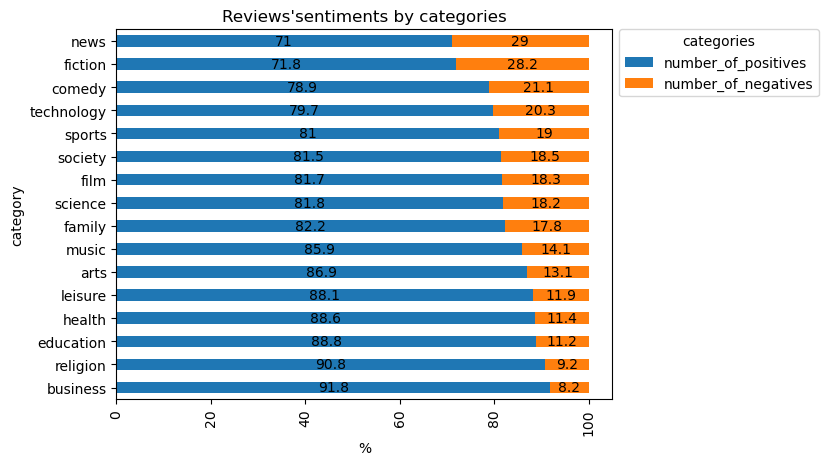

In [110]:
stacked_bars(reviews_s_grouped_percent,"categories","Reviews'sentiments by categories")

It can be seen from the plot that the highest difference in proportion of numbers of positive sentiments is among fiction, news, and film categories on the one hand and education, business, and religion categories on the other hand. Also, it can be assumed that differences among fiction, news, and film categories are not statistically significant as well as differences among religion, business, and education categories (because they are two small).

#### Chi square test:

The Pearson chi square test of association between categorical variables confirmed that there is a statistically significant relationship between sentiments in reviews and categories of podcasts (p<0.05).

In [111]:
chi_square_test(reviews_s2_grouped)

Pearson chi square test:399.582

P_value: 0.0
Dependent (reject H0)


#### Permutation test:

In [112]:
permutation_test(reviews_cs2,reviews_cs4, 'label', 'category')
permutation_test(reviews_cs2,reviews_cs7, 'label', 'category')
permutation_test(reviews_cs2,reviews_cs8, 'label', 'category')
permutation_test(reviews_cs3,reviews_cs4, 'label', 'category')
permutation_test(reviews_cs3,reviews_cs7, 'label', 'category')
permutation_test(reviews_cs3,reviews_cs8, 'label', 'category')
permutation_test(reviews_cs10,reviews_cs4, 'label', 'category')
permutation_test(reviews_cs10,reviews_cs7, 'label', 'category')
permutation_test(reviews_cs10,reviews_cs8, 'label', 'category')
permutation_test(reviews_cs2,reviews_cs3, 'label', 'category')
permutation_test(reviews_cs2,reviews_cs10, 'label', 'category')
permutation_test(reviews_cs3,reviews_cs10, 'label', 'category')
permutation_test(reviews_cs4,reviews_cs7, 'label', 'category')
permutation_test(reviews_cs4,reviews_cs8, 'label', 'category')
permutation_test(reviews_cs7,reviews_cs8, 'label', 'category')

Hypothesis H0 that samples <business> and <news> are from the same distribution is not approved.
 The alternative hypothesis holds.
p_value: 0.0

Hypothesis H0 that samples <business> and <film> are from the same distribution is not approved.
 The alternative hypothesis holds.
p_value: 0.0

Hypothesis H0 that samples <business> and <fiction> are from the same distribution is not approved.
 The alternative hypothesis holds.
p_value: 0.0

Hypothesis H0 that samples <education> and <news> are from the same distribution is not approved.
 The alternative hypothesis holds.
p_value: 0.0

Hypothesis H0 that samples <education> and <film> are from the same distribution is not approved.
 The alternative hypothesis holds.
p_value: 0.0

Hypothesis H0 that samples <education> and <fiction> are from the same distribution is not approved.
 The alternative hypothesis holds.
p_value: 0.0

Hypothesis H0 that samples <religion> and <news> are from the same distribution is not approved.
 The alternative h

The results of the permutation tests confirm the assumption about the independence of samples from business, religion and education categories on the one hand and film, news, and fiction categories on the other hand. All tests rejected the null hypothesis that these samples are from the same distribution.

Also the assumption that within the mentioned groups the differences between categories in both groups are not statistically significant was mostly approved, with on exception - the permutation test indicated that samples for categories of news and film are independent.

#### Confidence intervals:

In [113]:
confidence_interval_proportion(reviews_cs0, 'label','POSITIVE', 'category')
confidence_interval_proportion(reviews_cs1, 'label','POSITIVE', 'category')
confidence_interval_proportion(reviews_cs2, 'label','POSITIVE', 'category')
confidence_interval_proportion(reviews_cs3, 'label','POSITIVE', 'category')
confidence_interval_proportion(reviews_cs4, 'label','POSITIVE', 'category')
confidence_interval_proportion(reviews_cs5, 'label','POSITIVE', 'category')
confidence_interval_proportion(reviews_cs6, 'label','POSITIVE', 'category')
confidence_interval_proportion(reviews_cs7, 'label','POSITIVE', 'category')
confidence_interval_proportion(reviews_cs8, 'label','POSITIVE', 'category')
confidence_interval_proportion(reviews_cs9, 'label','POSITIVE', 'category')
confidence_interval_proportion(reviews_cs10, 'label','POSITIVE', 'category')
confidence_interval_proportion(reviews_cs11, 'label','POSITIVE', 'category')
confidence_interval_proportion(reviews_cs12, 'label','POSITIVE', 'category')
confidence_interval_proportion(reviews_cs13, 'label','POSITIVE', 'category')
confidence_interval_proportion(reviews_cs14, 'label','POSITIVE', 'category')
confidence_interval_proportion(reviews_cs15, 'label','POSITIVE', 'category')

Confidence intervals for number of POSITIVE in the <label> variable of <society> sample: 
(0.7909335097346921, 0.8390664902653078)
Confidence intervals for number of POSITIVE in the <label> variable of <comedy> sample: 
(0.7637112233785354, 0.8142887766214647)
Confidence intervals for number of POSITIVE in the <label> variable of <business> sample: 
(0.9009950109030741, 0.935004989096926)
Confidence intervals for number of POSITIVE in the <label> variable of <education> sample: 
(0.8684537438758478, 0.9075462561241522)
Confidence intervals for number of POSITIVE in the <label> variable of <news> sample: 
(0.6818760534209559, 0.738123946579044)
Confidence intervals for number of POSITIVE in the <label> variable of <sports> sample: 
(0.785685384796283, 0.8343146152037171)
Confidence intervals for number of POSITIVE in the <label> variable of <health> sample: 
(0.8663022156899465, 0.9056977843100535)
Confidence intervals for number of POSITIVE in the <label> variable of <film> sample: 
(0

In [114]:
confidence_intervals_difference(reviews_cs2,reviews_cs4,1000, 'label','POSITIVE','category', 0.95)
confidence_intervals_difference(reviews_cs2,reviews_cs7,1000, 'label','POSITIVE','category', 0.95)
confidence_intervals_difference(reviews_cs2,reviews_cs8,1000, 'label','POSITIVE','category', 0.95)
confidence_intervals_difference(reviews_cs3,reviews_cs4,1000, 'label','POSITIVE','category', 0.95)
confidence_intervals_difference(reviews_cs3,reviews_cs7,1000, 'label','POSITIVE','category', 0.95)
confidence_intervals_difference(reviews_cs3,reviews_cs8,1000, 'label','POSITIVE','category', 0.95)
confidence_intervals_difference(reviews_cs10,reviews_cs4,1000, 'label','POSITIVE','category', 0.95)
confidence_intervals_difference(reviews_cs10,reviews_cs7,1000, 'label','POSITIVE','category', 0.95)
confidence_intervals_difference(reviews_cs10,reviews_cs8,1000, 'label','POSITIVE','category', 0.95)
confidence_intervals_difference(reviews_cs2,reviews_cs3,1000, 'label','POSITIVE','category', 0.95)
confidence_intervals_difference(reviews_cs2,reviews_cs10,1000, 'label','POSITIVE','category', 0.95)
confidence_intervals_difference(reviews_cs3,reviews_cs10,1000, 'label','POSITIVE','category', 0.95)
confidence_intervals_difference(reviews_cs4,reviews_cs7,1000, 'label','POSITIVE','category', 0.95)
confidence_intervals_difference(reviews_cs4,reviews_cs8,1000, 'label','POSITIVE','category', 0.95)
confidence_intervals_difference(reviews_cs7,reviews_cs8,1000, 'label','POSITIVE','category', 0.95)


There is a 95.0 chance that the confidence interval of (0.175, 0.241) contains the true difference 
in the proportion of POSITIVE sentiments between reviews for podcasts in <business> and <news> categories.

Since this interval does not contain the value “0” it means 
that it’s highly likely that there is a true difference in the proportion 
of POSITIVE sentiments between reviews for podcasts 
 in <business> and <news> categories.

There is a 95.0 chance that the confidence interval of (0.072, 0.13) contains the true difference 
in the proportion of POSITIVE sentiments between reviews for podcasts in <business> and <film> categories.

Since this interval does not contain the value “0” it means 
that it’s highly likely that there is a true difference in the proportion 
of POSITIVE sentiments between reviews for podcasts 
 in <business> and <film> categories.

There is a 95.0 chance that the confidence interval of (0.167, 0.233) contains the true difference 
in the proportion of POSITIVE

It can be seen that the same assumptions about differences and similarities among numbers of positive review sentiments among samples for different podcast categories were confirmed, with the exception that that the confidence intervals of sample differences indicated that the true difference is likely among news and film samples and film and fiction samples (the permutation for this pair did not refuted the null hypothesis).

### Is there a positive relationship between reviews' sentiments and ratings given to podcasts by reviewers?

In this part the results of the analysis of the relationship between reviews' sentiments and ratings given to podcasts by reviewers will be presented. Based on the common sense it was assumed that there should be positive relationship between these variables - reviewers who express positive sentiments give better ratings and vice versa. If the assumption is confirmed by the statistical analysis, it could also be an additional indication that sentiment analysis conducted by the pre-trained model is reliable.

#### Relationship between rating and numbers of positive or negative sentiments:

A random sample of 1000 was taken from the total pool of reviews. 

In [115]:
reviews_s22 = sample_reviews_sentiments(reviews_full, 1000)

Data from the sample were selected for the purpose of further analysis. It was decided to treat rating as a categorical variable. 

In [116]:
reviews_s22_grouped = duckdb.sql("""SELECT
                        rating,
                        COUNT(CASE WHEN label = 'POSITIVE' THEN rating END) AS number_of_positives,
                        COUNT(CASE WHEN label = 'NEGATIVE' THEN rating END) AS number_of_negatives
                        FROM reviews_s22
                        GROUP BY rating
                        """).df().set_index('rating')
reviews_s22_grouped

,number_of_positives,number_of_negatives
rating,,
5,802,82
1,9,46
4,13,7
3,6,17
2,7,11


The chi square test confirmed that there is a statistical significant relationship between ratings and numbers of positive of negative sentiments. 

In [117]:
chi_square_test(reviews_s22_grouped)

Pearson chi square test:302.332

P_value: 0.0
Dependent (reject H0)


The percentage date were plotted with the stacked bar plot.

In [118]:
reviews_s22_grouped_percent = (get_percent(reviews_s22_grouped.transpose())*100).round(2)
reviews_s22_grouped_percent = reviews_s22_grouped_percent.transpose().\
sort_values("number_of_positives", ascending=False)


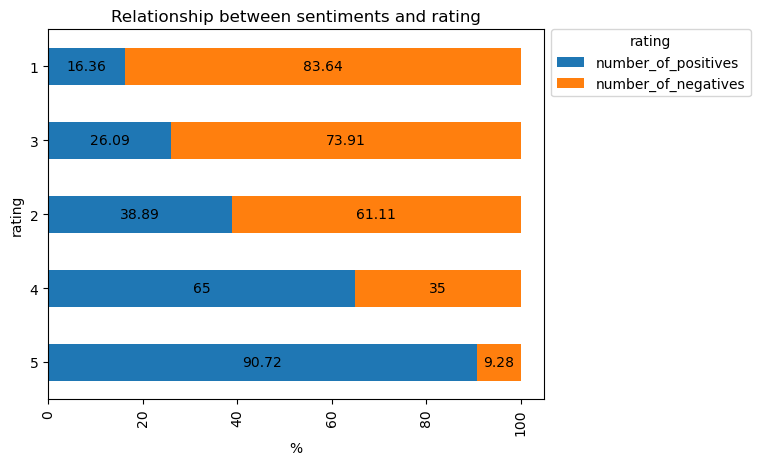

In [119]:
stacked_bars(reviews_s22_grouped_percent,"rating","Relationship between sentiments and rating")

#### Ralationship between rating and scores of positive sentiments:

Next, it was decided to examine relationship between rating scores and scores of positive and negative sentiments which indicate what degree sentiment categories "POSITIVE" or "NEGATIVE" represent the true meaning of the review content (for example, if a review is more neutral than positive it will receive lower score).

For this purpose, data from the sample on scores of positive and negative sentiments were saved into separate dataframes.

In [120]:
reviews_s23_grouped = duckdb.sql("""SELECT
                        rating,
                        score AS score_of_positives
                        FROM reviews_s22
                        WHERE label = 'POSITIVE'
                        """).df()


In [121]:
reviews_s25_grouped = duckdb.sql("""SELECT
                        rating,
                        score AS score_of_negatives
                        FROM reviews_s22
                        WHERE label = 'NEGATIVE'
                        """).df()

Correlation coefficients between rating and scores 0f positive and negative sentiments were counted by treating rating variable as numerical in this case. It appeared that correlation coefficients are quite low thus it could be concluded that the variables are not correlated. 

In [122]:
corr, p_value = st.pearsonr(reviews_s23_grouped['rating'], reviews_s23_grouped['score_of_positives'])
print(f'Relationship between mean scores of POSITIVE sentiments and ratings - correlation coeficient: {corr.round(3)}')
print(f'P-value: {p_value.round(3)}')
print('')
corr, p_value = st.pearsonr(reviews_s25_grouped['rating'], reviews_s25_grouped['score_of_negatives'])
print(f'Relationship between mean scores of NEGATIVE sentiments and ratings - Correlation coeficient: {corr.round(3)}')
print(f'P-value: {p_value.round(3)}')

Relationship between mean scores of POSITIVE sentiments and ratings - correlation coeficient: 0.14
P-value: 0.0

Relationship between mean scores of NEGATIVE sentiments and ratings - Correlation coeficient: -0.266
P-value: 0.001


#### ANOVA test and Kruscal Wallis test:

Also, ANOVA and Kruscal Wallis tests were conducted in order to test if there are statistically signifficant differences between rating scores (trated as categorical variables) and means of sentiment scores.

In [123]:
reviews_s24_grouped = duckdb.sql("""SELECT
                        rating,
                        CASE WHEN label = 'POSITIVE' THEN score END AS positive_score,
                        CASE WHEN label = 'NEGATIVE' THEN score END AS negative_score
                        FROM reviews_s22
                        """).df().round(2)
reviews_s24_grouped.head()

,rating,positive_score,negative_score
0,5,0.99,NaN
1,1,0.93,NaN
2,5,1.00,NaN
3,4,1.00,NaN
4,5,0.99,NaN


In [124]:
x1 = list(reviews_s24_grouped["positive_score"][reviews_s24_grouped["rating"] == 1].dropna())
x2 = list(reviews_s24_grouped["positive_score"][reviews_s24_grouped["rating"] == 2].dropna())
x3 = list(reviews_s24_grouped["positive_score"][reviews_s24_grouped["rating"] == 3].dropna())
x4 = list(reviews_s24_grouped["positive_score"][reviews_s24_grouped["rating"] == 4].dropna())
x5 = list(reviews_s24_grouped["positive_score"][reviews_s24_grouped["rating"] == 5].dropna())

In [125]:
x6 = list(reviews_s24_grouped["negative_score"][reviews_s24_grouped["rating"] == 1].dropna())
x7 = list(reviews_s24_grouped["negative_score"][reviews_s24_grouped["rating"] == 2].dropna())
x8 = list(reviews_s24_grouped["negative_score"][reviews_s24_grouped["rating"] == 3].dropna())
x9 = list(reviews_s24_grouped["negative_score"][reviews_s24_grouped["rating"] == 4].dropna())
x10 = list(reviews_s24_grouped["negative_score"][reviews_s24_grouped["rating"] == 5].dropna())

In [126]:
review_s25_grouped = reviews_s24_grouped.groupby("rating").mean().round(2)
review_s25_grouped.transpose()

rating,1,2,3,4,5
positive_score,0.93,0.99,0.99,0.96,0.99
negative_score,0.99,0.98,0.97,1.00,0.93


In [127]:
statistics1, p_value1 = f_oneway(x1,x2,x3,x4,x5)
statistics2, p_value2 = f_oneway(x6,x7,x8,x9,x10)
print(f'ANOVA test result for mean scores of POSITIVE sentiments:\nStatistics: {statistics1},\nP-value:{p_value1}')
print(f'ANOVA test result for mean scores of NEGATIVE sentiments:\nStatistics: {statistics2},\nP-value:{p_value2}')

ANOVA test result for mean scores of POSITIVE sentiments:
Statistics: 6.60646055622549,
P-value:3.097556508089234e-05
ANOVA test result for mean scores of NEGATIVE sentiments:
Statistics: 3.5094920893109323,
P-value:0.00894390721001598


It can be seen that the ANOVA test confirmed statistically sigificant differences between means of positive and negative sentiment scores among different rating groups.

The nonparametric Kruscal Wallis test (which is used to test if there are statistically significant differences between more than two groups) rejected the null hypothesis both for positive and negative sentiments.

In [128]:
print('Mean scores of POSITIVE sentiments:')
kruscal_wallis_test(x1,x2,x3,x4,x5)
print('')
print('Mean scores of NEGATIVE sentiments:')
kruscal_wallis_test(x1,x2,x3,x4,x5)

Mean scores of POSITIVE sentiments:
Kruscal Wallis test:

Statistics=41.580, p=0.000
Different distributions (reject H0)


Mean scores of NEGATIVE sentiments:
Kruscal Wallis test:

Statistics=41.580, p=0.000
Different distributions (reject H0)



In order to better examine the relationship between rating scores and mean scores of positive and negative sentiments, the data were plotted with the scatter plots. 

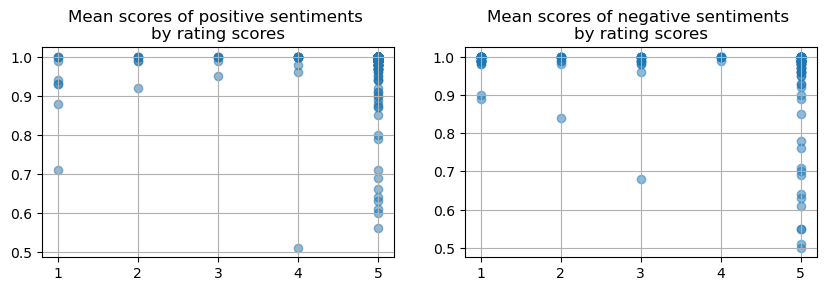

In [129]:
plt.rcParams["figure.figsize"] = (10,6) 

plt.subplot(2,2,1)
plt.scatter(reviews_s24_grouped['rating'], reviews_s24_grouped['positive_score'], alpha=0.5)
plt.title("Mean scores of positive sentiments \nby rating scores")
plt.grid()

plt.subplot(2,2,2)
plt.scatter(reviews_s24_grouped['rating'], reviews_s24_grouped['negative_score'], alpha=0.5)
plt.title("Mean scores of negative sentiments \nby rating scores")
plt.grid()

It can be observed that there is a relationship between rating scores and mean scores of positive and negative sentiments - by examining means of negative and positive scores in different rating groups it is possible to identify the trend that higher ratings for negative sentiments have lower mean sentiment scores and lower ratings for positive sentiments have lower mean sentiment scores.


## Conclusions and suggestions for improvement

The following conclusions can be made after the data analysis of the Podcast Reviews data set:
- Among podcasts included into the Podcast Reviews dataset (in total 110024 podcasts)  from 2005 to 2023 the highest percent of podcasts belongs to the 'society' category (12.99 %), also to 'religion' (11.04 %) and business (10.79 %) categories.
- A small number of podcasts has no title (15), for some podcasts more than one category is attached. Some podcasts are with the same titles.
- 14.61 % podcast reviews belongs to the 'society' category, 9.75 % to 'business' category and 9,28 % to 'comedy' category. For some categories there are proportionaly more reviews than podcasts and for other categories there are proportionally more podcasts than reviews.
- Podcasts with the higher number of reviews are 'Crime Junkie' (fiction), 'My Favorite Murder with Karen Kilgariff and Georgia Hardstark' (comedy, fiction) and 'Wow in the World' (education). There are 15592 podcasts reviewed just one review.
- 83036 podcasts received maximum average rating 5 which is the most widespread assesment of podcasts (almost 87 percent from all reviews were with such a rating).
- The most reviewed podcasts are not among the best reviewed podcasts as neither of them receive the maximum average ratings.
-  the podcasts on air for the longest time ('All Songs Considered', 'Democracy Now! Audio', 'PotterCat: The Harry Potter Podcast') do not receive the highest average ratings.
- Podcasts on such topics as business, religion and education receive higher ratings while podcasts on such topics as technologies, news and fiction receive lower ratings.
- On the top 10 are the authors who wrote more than 300 reviews and their gave almost maximum ratings to the podcasts they reviewed. There is just a small number of authors who wrote a high number of reviews while a high majority of reviewers wrote a review just once.
- The correlation analysis revealed that there is no strong correlation between numbers of reviews ier author and average ratings of reviews.
- The highest percent of reviewers contributed to podcasts of society, business, comedy and education topics while the topics of science, music and technology were the least popular among reviewers.
-  Average ratings of podcasts on such topics as news and business were lower in the time of economic crisis (years 2009 - 2012) comparing to average ratings in the following years. For such topics as religion and fiction average ratings were higher in the time of economic crisis, then ratings gradualy decreased in the following years.
- Numbers of reviews in all categories started to exponentially increase since 2016, however, the numbers decreased since the year 2022.
-  Sentiment analysis from random samples revealed that the lowest number of positive reviews is associated with the economic crisis periods (2010 - 2012) and (2020 - 2023). It could be assumed that economic and health difficulties, pandemic restrictions and political tensions (the war in the Ukraine, etc.) negatively affected the psychological climate of the world population and it got expressed in the less positive podcast reviews.
- The highest difference in proportion of numbers of positive sentiments is among fiction, news, and film categories on the one hand and education, business, and religion categories on the other hand. Also, it can be assumed that differences among fiction, news, and film categories are not statistically significant as well as differences among religion, business, and education categories (because they are two small).
- There is a statistical significant relationship between ratings and numbers of positive of negative sentiments.
- By examining means of negative and positive scores in different rating groups it is possible to identify the trend that higher ratings for negative sentiments have lower mean sentiment scores and lower ratings for positive sentiments have lower mean sentiment scores. But there is no strong correlation between ratings of reviews and scores of positive or negative sentiments.

#### Limitations and suggestions for improvement:

- Only few potential hypotheses about relationships between variables in the surveys were tested.
- It would be possible to use other models for sentiment classification with more than two categories (not only positive and negative but also neutral or else).
- Sentiment classification models could be trained on the reviews content data.




## Google Data Studio charts

Here is the link to the Google Data Studio charts:

https://lookerstudio.google.com/reporting/335074d5-dad3-4ffc-ae55-9b59f6c82b2c


## References:

1. Pascual Federico (2022). Getting Started with Sentiment Analysis using Python, Hugging Face, https://huggingface.co/blog/sentiment-analysis-python
2. Stuart Axelbrooke. (2023). Podcast Reviews. [Data set]. Kaggle. https://www.kaggle.com/dsv/5018221 doi:10.34740/KAGGLE/DSV/5018221